In [1]:
import os
import torch
import math
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import colors, cm
import seaborn as sns
import networkx as nx
import torch_geometric as pyg
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm, SymLogNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import Normalize
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
from scipy import stats
from matplotlib.ticker import LogLocator, NullFormatter
from matplotlib.gridspec import GridSpec
from collections import Counter

# Section 1. Runtime
## 1.1 inference time and preprocess time

In [73]:
datasets = ['Set_1', 'Set_2', 'Set_3', 'Set_5', 'Set_7', 'Set_8', 'Set_9', 'Set_10']
dataset_name = {
    "Set_1": 'Set 1',
    "Set_2": 'Set 2',
    "Set_3": 'Set 3',
    "Set_5": 'Set 4',
    "Set_7": 'Set 5',
    "Set_8": 'Set 6',
    "Set_9": 'Set 7',
    "Set_10": 'Set 8'
}
algs = ['ESCAPE', 'EVOKE', 'MOTIVO', 'DeSCo', 'GNN', 'GNNAK', 'IDGNN', 'ESC-GNN', 'I2GNN', 'PPGN']

In [74]:
def get_inf_pre_time(dataset, alg):
    file_path_prefix = f'output/runtime/{dataset}/{alg}'
    if alg in ['ESCAPE', 'EVOKE', 'MOTIVO', 'DeSCo']:
        file_path = os.path.join(file_path_prefix, 'target_all.json')
        try:
            with open(file_path, 'r') as f:
                data = json.load(f).get('time_profile', {})
            if alg == 'DeSCo':
                return data.get('inference', None), data.get('pre_transform', None)
            else:
                return data.get('inference', None), None
        except:
            return None, None
    else:
        file_path = [file_path_prefix + f'/target_{t}.json' for t in [0, 1, 2, 8]]
        try:
            inf_times = []
            for file in file_path:
                with open(file, 'r') as f:
                    data = json.load(f)['time_profile']
                inf_times.append(data.get('inference', None))
            if any(t is None for t in inf_times):
                return None, None
            inference_time = 19 * inf_times[0] + 3 * inf_times[1] + 6 * inf_times[2] + 1 * inf_times[3]

            if alg == 'GNN' or alg == 'PPGN':
                return inference_time, 0

            pretransform_time = 0
            with open('output/load_time.json', 'r') as f:
                if alg == 'GNNAK':
                    data = json.load(f)[dataset]['IDGNN']
                else:
                    data = json.load(f)[dataset][alg]
            for i in [0, 1, 2, 8]:
                for split in ['train', 'val', 'test']:
                    pretransform_time += data[str(i)][split]
            pretransform_time /= 6
            return inference_time, pretransform_time
        except:
            return None, None

In [75]:
# make a plots with 2 * 4 subplots for each dataset, and compare the inference time and preprocessing time. Draw the bar plot for each algorithm, and the two time bar in the same subplot.
data_dict = {dataset: {'inference': [], 'preprocessing': []} for dataset in datasets}
for dataset in datasets:
    for alg in algs:
        inf_time, pre_time = get_inf_pre_time(dataset, alg)
        data_dict[dataset]['inference'].append((alg, inf_time))
        data_dict[dataset]['preprocessing'].append((alg, pre_time))

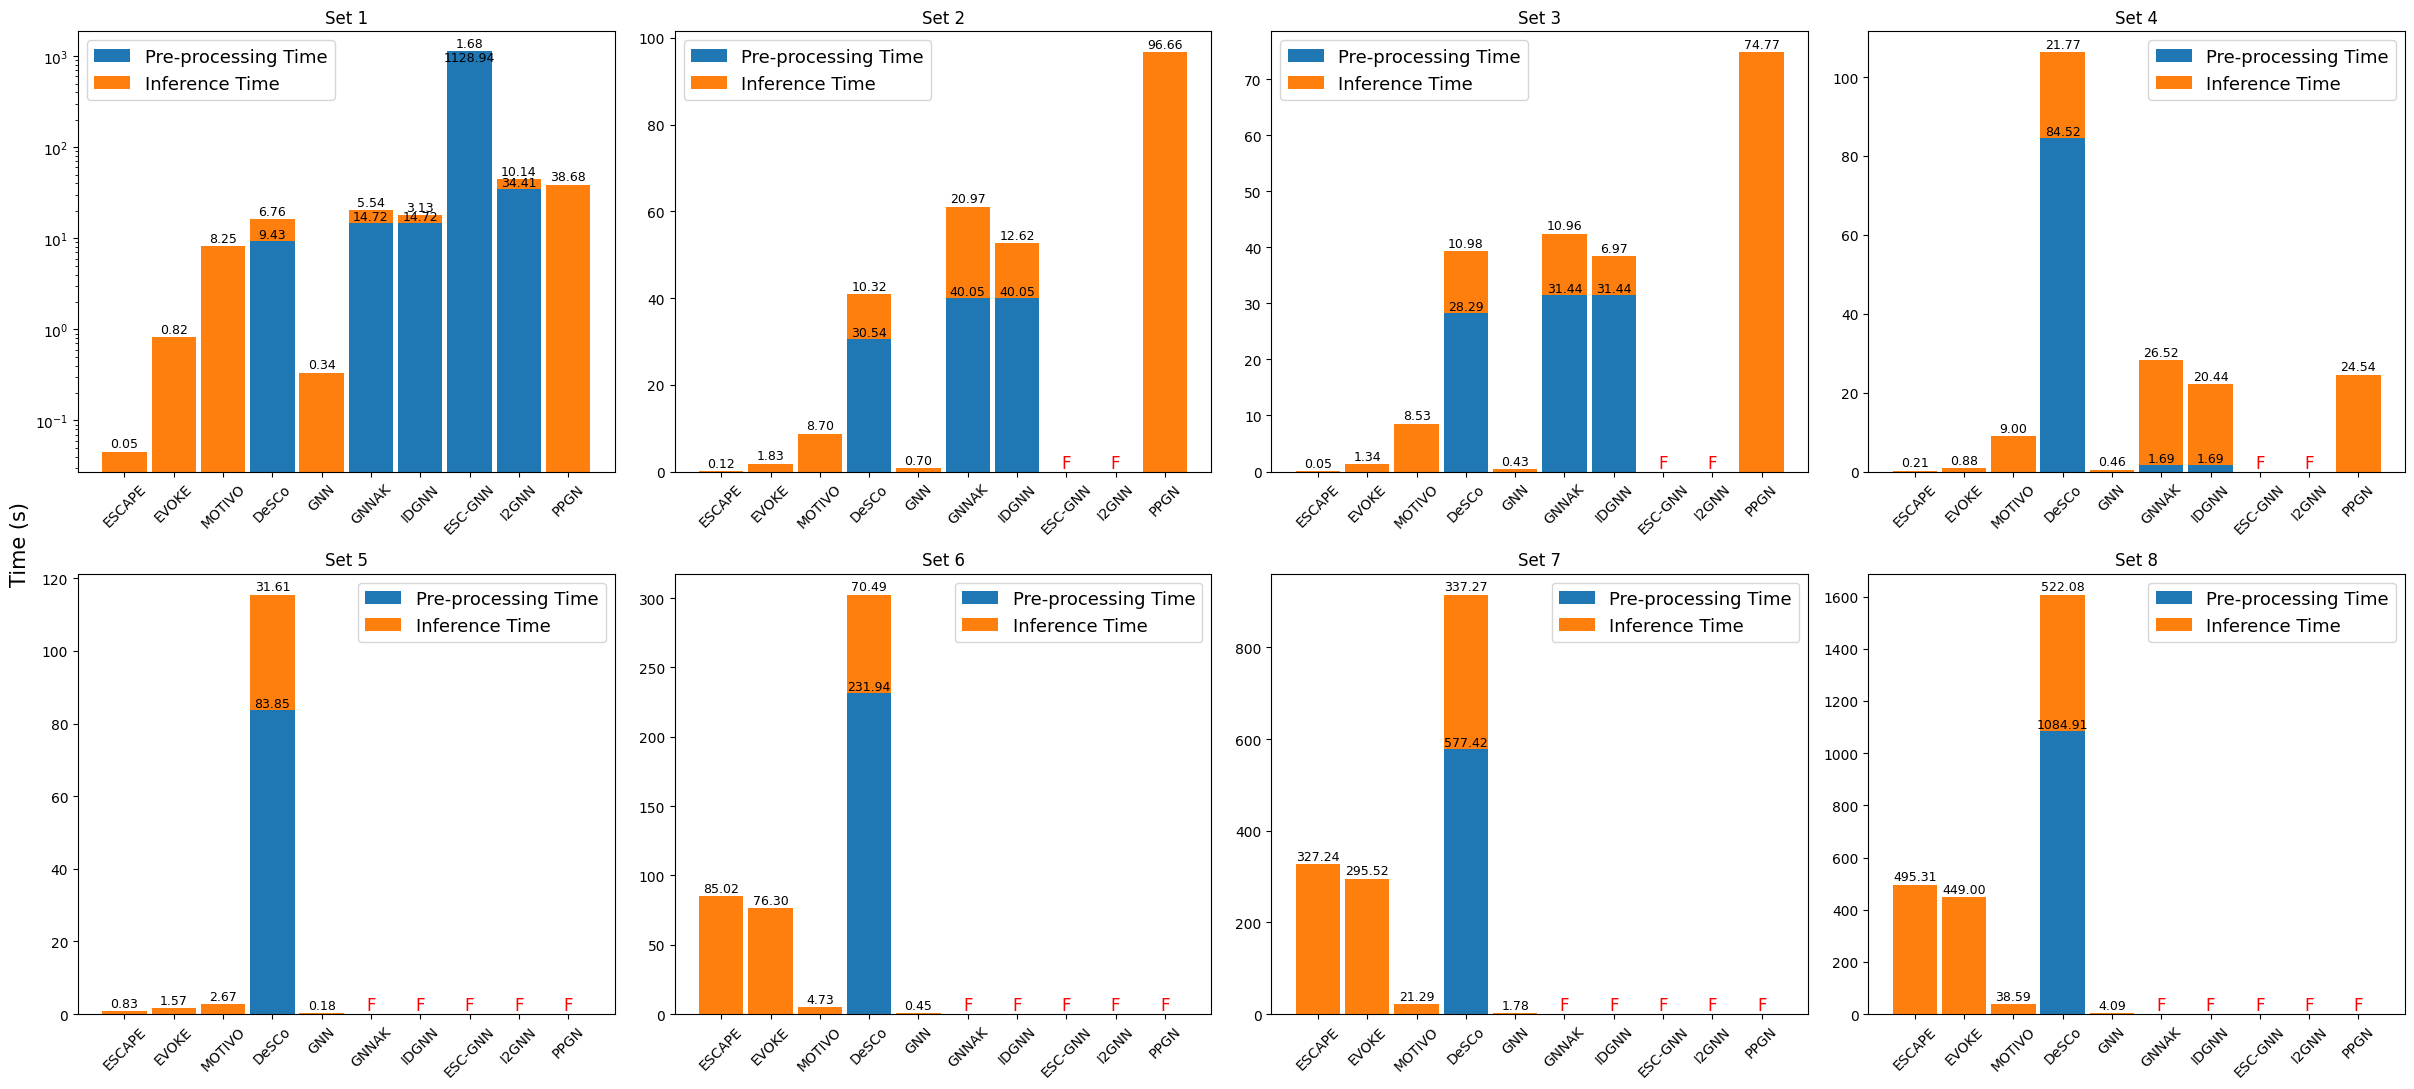

In [78]:
# Plotting
fig, axes = plt.subplots(2, 4, figsize=(24, 11))  # 2 rows x 4 columns for 8 datasets
axes = axes.flatten()  # Flatten to 1D for easy iteration

# Define bar width and positions
bar_width = 0.9  # Increased width for better visibility
indices = np.arange(len(algs))  # the label locations

for idx, dataset in enumerate(datasets):
    ax = axes[idx]
    
    # Extract inference and preprocessing times
    inf_items = data_dict[dataset]['inference']
    pre_items = data_dict[dataset]['preprocessing']
    
    inf_times = [item[1] for item in inf_items]
    pre_times = [item[1] for item in pre_items]
    
    # Initialize arrays for stacking
    preprocess_values = [pre_time if pre_time is not None else 0 for pre_time in pre_times]  # Bottom layer
    inference_values = [inf_time if inf_time is not None else 0 for inf_time in inf_times]  # Top layer
    
    # Plot preprocessing times
    bars_pre = ax.bar(indices, preprocess_values, bar_width, label='Pre-processing Time', color='#1f77b4')
    
    # Plot inference times on top of preprocessing
    bars_inf = ax.bar(indices, inference_values, bar_width, bottom=preprocess_values, 
                      label='Inference Time', color='#ff7f0e')
    
    # Annotate 'Failed' where inference_time is None
    for i, (alg, inf_time) in enumerate(inf_items):
        if inf_time is None:
            # Position the 'Failed' text at the top of the preprocessing bar
            ax.text(indices[i], preprocess_values[i], 'F', ha='center', va='bottom', 
                    rotation=0, fontsize=12, color='red')
    
    # # Annotate 'N/A' where preprocessing_time is 0 and pre_time was present
    # for i, (alg, pre_time) in enumerate(pre_items):
    #     if pre_time == 0 and pre_time is not None:
    #         # Position the 'N/A' text at the base of inference bar
    #         ax.text(indices[i], 0, 'N/A', ha='center', va='bottom', 
    #                 rotation=90, fontsize=8, color='gray')
    

    # set y-axis as log scale
    if idx == 0:
        ax.set_yscale('log')

    # Add labels, title, and set x-axis ticks
    # ax.set_xlabel('Algorithms')
    # ax.set_ylabel('Time (s)')
    # ax.set_title(f'Time Comparison for {dataset}')
    ax.set_title(f'{dataset_name[dataset]}')
    ax.set_xticks(indices)
    ax.set_xticklabels(algs, rotation=45, ha='center')
    
    # Create a single legend per subplot
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), fontsize=13)
    
    # Annotate bars with their heights
    # First, annotate preprocessing bars
    for rect, pre_time in zip(bars_pre, preprocess_values):
        if pre_time > 0:
            height = rect.get_height()
            ax.annotate(f'{pre_time:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 0),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom' if pre_time < 1100 else 'top', fontsize=9)
    
    # Then, annotate inference bars
    for rect, inf_time in zip(bars_inf, inference_values):
        if inf_time > 0:
            height = rect.get_height()
            ax.annotate(f'{inf_time:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, rect.get_y() + height),
                        xytext=(0, 1),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9)

# Adjust layout to prevent overlap
plt.tight_layout()

# add x title and y title for the whole figure
# fig.text(0.5, 0, 'Algorithms', ha='center', va='center', fontsize=15)
fig.text(0., 0.5, 'Time (s)', ha='center', va='center', rotation='vertical', fontsize=15)

# Save the plot
os.makedirs('plots/runtime', exist_ok=True)

# save vectorized pdf
plt.savefig('plots/final/runtime_comparison.pdf', format='pdf', bbox_inches='tight')

## 1.2 training time

In [ ]:
datasets = ['Set_1', 'Set_2', 'Set_3', 'Set_5', 'Set_7', 'Set_8', 'Set_9', 'Set_10']
algs = ['DeSCo', 'DeSCo-T', 'GNN', 'GNNAK', 'IDGNN', 'ESC-GNN', 'I2GNN', 'PPGN']

In [6]:
def get_training_time(dataset, alg):
    if alg == 'DeSCo' or alg == 'DeSCo-T':
        file_path = f'output/runtime/{dataset}/DeSCo/target_all.json'
        try:
            with open(file_path, 'r') as f:
                data = json.load(f).get('time_profile', {})
            if alg == 'DeSCo':
                hop_times = data.get('training', None)
                if hop_times is None or len(hop_times) < 4:
                    return None
                training_time = 3 * hop_times[0] + 19 * hop_times[1] + 6 * hop_times[2] + 1 * hop_times[3]
                training_time = 200 * training_time / 3600
            else:
                training_time = data.get('training_together', None)
                if training_time is None:
                    return None
                training_time = 2000 * training_time / 3600 / 300
            return training_time/29*60
        except:
            return None
    else:
        file_path_prefix = f'output/runtime/{dataset}/{alg}/target_'
        file_path = [file_path_prefix + f'{t}.json' for t in [0, 1, 2, 8]]
        try:
            hop_times = []
            for file in file_path:
                with open(file, 'r') as f:
                    data = json.load(f).get('time_profile', {})
                hop_times.append(data.get('training', None))
            if any(t is None for t in hop_times):
                return None
            training_time = 19 * hop_times[0] + 3 * hop_times[1] + 6 * hop_times[2] + 1 * hop_times[3]
            training_time = 200 * training_time / 3600
            return training_time/29*60
        except:
            return None

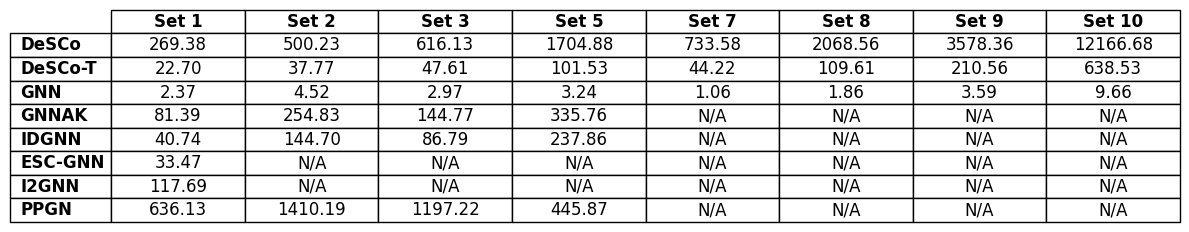

In [7]:
# Initialize a dictionary to store training times
training_times = {alg: [] for alg in algs}

# Populate the training_times dictionary
for alg in algs:
    for dataset in datasets:
        time = get_training_time(dataset, alg)
        training_times[alg].append(time)

# Convert to pandas DataFrame for better handling
df = pd.DataFrame(training_times, index=[d.replace('_', ' ') for d in datasets]).T  # Algorithms as rows, Datasets as columns

# Replace None with np.nan for consistent handling of missing data
df = df.replace({None: np.nan})

# Function to format the DataFrame for display
def format_table_data(df):
    """
    Convert the DataFrame into a list of lists with formatted strings.
    Numerical values are formatted to two decimal places.
    Missing values are represented as 'N/A'.
    """
    table_data = []
    for alg in df.index:
        row = []
        for value in df.loc[alg]:
            if pd.isna(value):
                row.append('N/A')
            else:
                row.append(f"{value:.2f}")
        table_data.append(row)
    return table_data

# Prepare the table data
formatted_table = format_table_data(df)

# Start plotting
fig, ax = plt.subplots(figsize=(12, 2.4))  # Reduced height from (10, 8) to (10, 5)

# Hide axes
ax.axis('off')

# Optional: Adjust subplot parameters to minimize margins
plt.subplots_adjust(left=0.2, right=0.95, top=0.85, bottom=0.15)

# Create the table
table = ax.table(cellText=formatted_table,
                 rowLabels=df.index,
                 colLabels=df.columns,
                 cellLoc='center',
                 loc='center',
                 edges='closed')  # 'closed' ensures that cell borders are drawn

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.0, 1.2)  # Adjusted scaling: horizontal scaling to 1.0, vertical to 1.2

# Set header row and column labels font to bold
for (row, col), cell in table.get_celld().items():
    if row == 0:
        # Column headers
        cell.get_text().set_fontweight('bold')
        cell.set_edgecolor('black')
    if col == -1:
        # Row labels (algorithm names)
        cell.get_text().set_fontweight('bold')
        cell.set_edgecolor('black')
    else:
        cell.set_edgecolor('black')  # Cell borders

# Adjust layout to make sure everything fits without overlap
plt.tight_layout()

# Optionally, save the table as an image
plt.savefig('plots/final/training_time.pdf', bbox_inches='tight')

# Section 2. Accuracy (Set_1)
## 2.1 Zero-shot

In [49]:
num_nodes = torch.tensor([3] * 2 + [4] * 6 + [5] * 21)
pattern_index = [6, 7, 14, 13, 16, 15, 17, 18, 31, 30, 29, 35, 36, 34, 38, 37, 40, 42, 41, 44, 43, 46, 45, 47, 48, 49, 50, 51, 52]
algs = ['MOTIVO', 'GNN', 'IDGNN', 'I2GNN', 'DeSCo', 'PPGN', 'GNNAK']
color_palette = {
    'Motivo': '#E74C3C',      # 深红色
    'DeSCo': '#3498DB',       # 明蓝色
    'GNN': '#2ECC71',         # 翠绿色
    'GNNAK': '#F39C12',       # 橙黄色
    'IDGNN': '#9B59B6',       # 紫色
    'ESC-GNN': '#1ABC9C',     # 青绿色
    'I2GNN': '#E91E63',       # 玫红色
    'PPGN': '#34495E'         # 深灰蓝色
}

dataset_name = 'Set_1'
dataset = torch.load(os.path.join('input', dataset_name, 'dataset.pt'), weights_only=False)['test']
gt = torch.cat([torch.sum(g.gt_induced_le5[:, 1:], 0).reshape(1, -1) for g in dataset])
gt = torch.abs(gt) // num_nodes

selected_targets = [8, 10, 14, 15]

In [51]:
def get_graph_prediction(dataset_name, alg, target):
    if alg == 'DeSCo':
        file_path = f'output/{dataset_name}/DeSCo/pretrained/prediction_graph_ordered.csv'
        df = pd.read_csv(file_path, header=0, index_col=0)
        return df.iloc[:, target].values
    elif alg == 'MOTIVO':
        file_path = f'output/{dataset_name}/MOTIVO/prediction.csv'
        df = pd.read_csv(file_path, header=0, index_col=0)
        return df.iloc[:, target].values
    else:
        file_path = 'output/zero_shot_set_1_graph.json'
        f = json.load(open(file_path, 'r'))
        return f[alg][str(target)]['pred']

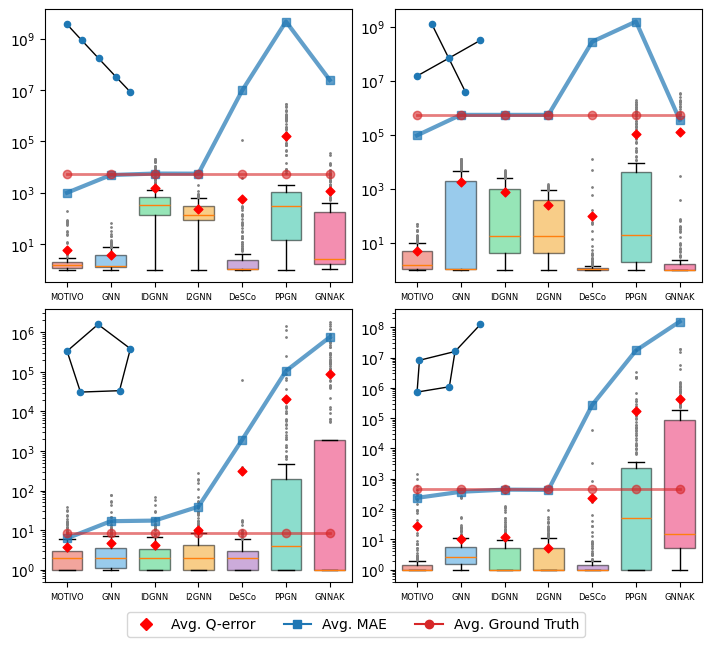

In [52]:
# Define flier properties with smaller markers
flier_props = dict(
    marker='o',
    markerfacecolor='gray',
    markersize=1,
    linestyle='none',
    markeredgecolor='gray'
)

# Create subplots with constrained layout
fig, axes = plt.subplots(2, 2, figsize=(7, 6), constrained_layout=True)
axes = axes.flatten()

for i, (target, ax) in enumerate(zip(selected_targets, axes)):
    results = {}
    gt_target = gt[:, target]
    
    # Collecting results for each algorithm
    for alg in algs:
        pred_graph = get_graph_prediction(dataset_name, alg, target)
        pred_graph = torch.tensor(pred_graph)
        
        # Calculate Q-Error
        qerror = (gt_target + 1) / (pred_graph + 1)
        qerror = torch.where(qerror > 1, qerror, 1 / qerror)
        
        # Calculate MAE
        mae = torch.abs(gt_target - pred_graph)
        
        results[alg] = {'qerror': qerror, 'mae': mae}

    # Prepare data for plotting
    qerror_data = []
    mae_data = []
    gt_data = []
    for method, data in results.items():
        qerror_data.append(data['qerror'].numpy())
        mae_data.append(np.mean(data['mae'].numpy()))
        gt_data.append(np.mean(gt_target.numpy()))
    
    # Plot boxplot for Q-Error with customized flierprops
    bp = ax.boxplot(
        qerror_data,
        positions=range(len(algs)),
        widths=0.7,
        patch_artist=True,
        flierprops=flier_props
    )
    
    # Set box colors
    for patch, color in zip(bp['boxes'], color_palette.values()):
        patch.set_facecolor(color)
        patch.set_alpha(0.5)
    
    # Add mean markers to the boxplot
    means = [np.mean(qerror) for qerror in qerror_data]
    ax.scatter(
        range(len(algs)),
        means,
        color='red',
        marker='D',
        s=20,
        zorder=3,
        label='Q-Error Mean'  # Temporarily adding label (will be handled in the global legend)
    )
    
    ax.set_yscale('log')
    # ax.set_ylim(1, 1000)
    # ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.grid(False)
    
    mae_line = ax.plot(
        range(len(algs)),
        mae_data,
        color='#1F77B4',
        marker='s',
        linewidth=3,
        markersize=6,
        alpha=0.7,
        label='MAE'  # Temporarily adding label
    )[0]
    
    gt_line = ax.plot(
        range(len(algs)),
        gt_data,
        color='#D62728',
        marker='o',
        linewidth=2,
        markersize=6,
        alpha=0.6,
        label='Avg. Ground Truth'  # Temporarily adding label
    )[0]
    
    # Add pattern inset
    ax_pattern = ax.inset_axes([0.05, 0.67, 0.25, 0.3])
    pattern = nx.graph_atlas(pattern_index[target])
    nx.draw(
        pattern,
        nx.spring_layout(pattern, seed=0),
        ax=ax_pattern,
        node_size=20,
        with_labels=False
    )
    ax_pattern.axis('off')
    
    # Set x-ticks
    ax.set_xticks(range(len(algs)))
    ax.set_xticklabels(algs, fontsize=6, ha='center')
    # ax2.yaxis.set_visible(False)

# Define legend handles (only once)
handles = [
    plt.Line2D(
        [], [],
        color='red', marker='D', linestyle='None',
        markersize=6, label='Avg. Q-error'
    ),
    plt.Line2D(
        [], [],
        color='#1F77B4', marker='s', linestyle='-',
        markersize=6, label='Avg. MAE'
    ),
    plt.Line2D(
        [], [],
        color='#D62728', marker='o', linestyle='-',
        markersize=6, label='Avg. Ground Truth'
    )
]

# Add a single legend to the top of the figure
fig.legend(
    handles=handles,
    loc='upper center',
    ncol=3,
    fontsize=10,
    bbox_to_anchor=(0.5, 0)  # Adjust the y-coordinate as needed
)

# tight layout
# plt.subplots_adjust(bottom=0.5)

# Save the plot
plt.savefig('plots/final/zero_shot_boxplot.pdf', bbox_inches='tight')

# Display the plot
plt.show()

## 2.2 Few-shot

In [56]:
num_nodes = torch.tensor([3] * 2 + [4] * 6 + [5] * 21)
pattern_index = [6, 7, 14, 13, 16, 15, 17, 18, 31, 30, 29, 35, 36, 34, 38, 37, 40, 42, 41, 44, 43, 46, 45, 47, 48, 49, 50, 51, 52]
algs = ['MOTIVO', 'GNN', 'IDGNN', 'I2GNN', 'DeSCo', 'PPGN', 'GNNAK']
color_palette = {
    'Motivo': '#E74C3C',      # 深红色
    'DeSCo': '#3498DB',       # 明蓝色
    'GNN': '#2ECC71',         # 翠绿色
    'GNNAK': '#F39C12',       # 橙黄色
    'IDGNN': '#9B59B6',       # 紫色
    'ESC-GNN': '#1ABC9C',     # 青绿色
    'I2GNN': '#E91E63',       # 玫红色
    'PPGN': '#34495E'         # 深灰蓝色
}
dataset_name = 'Set_1'
dataset = torch.load(os.path.join('input', dataset_name, 'dataset.pt'), weights_only=False)['test']
gt = torch.cat([torch.sum(g.gt_induced_le5[:, 1:], 0).reshape(1, -1) for g in dataset])
gt = torch.abs(gt) // num_nodes

selected_targets = [8, 10, 14, 15]

In [57]:
def get_graph_prediction(dataset_name, alg, target):
    if alg == 'DeSCo':
        file_path = f'output/{dataset_name}/DeSCo/finetuned/prediction_graph_ordered.csv'
        df = pd.read_csv(file_path, header=0, index_col=0)
        return df.iloc[:, target].values
    elif alg == 'MOTIVO':
        file_path = f'output/{dataset_name}/MOTIVO/prediction.csv'
        df = pd.read_csv(file_path, header=0, index_col=0)
        return df.iloc[:, target].values
    else:
        file_path = 'output/few_shot_set_1_graph.json'
        f = json.load(open(file_path, 'r'))
        return f[alg][str(target)]['pred']

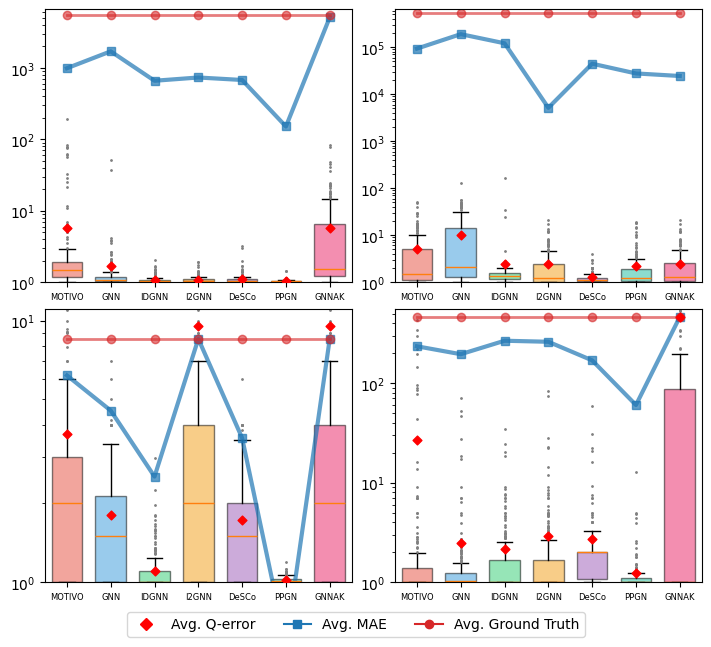

In [65]:
# Define flier properties with smaller markers
flier_props = dict(
    marker='o',
    markerfacecolor='gray',
    markersize=1,
    linestyle='none',
    markeredgecolor='gray'
)

# Create subplots with constrained layout
fig, axes = plt.subplots(2, 2, figsize=(7, 6), constrained_layout=True)
axes = axes.flatten()

for i, (target, ax) in enumerate(zip(selected_targets, axes)):
    results = {}
    gt_target = gt[:, target]
    
    # Collecting results for each algorithm
    for alg in algs:
        pred_graph = get_graph_prediction(dataset_name, alg, target)
        pred_graph = torch.tensor(pred_graph)
        
        # Calculate Q-Error
        qerror = (gt_target + 1) / (pred_graph + 1)
        qerror = torch.where(qerror > 1, qerror, 1 / qerror)
        
        # Calculate MAE
        mae = torch.abs(gt_target - pred_graph)
        
        results[alg] = {'qerror': qerror, 'mae': mae}

    # Prepare data for plotting
    qerror_data = []
    mae_data = []
    gt_data = []
    for method, data in results.items():
        qerror_data.append(data['qerror'].numpy())
        mae_data.append(np.mean(data['mae'].numpy()))
        gt_data.append(np.mean(gt_target.numpy()))
    
    # Plot boxplot for Q-Error with customized flierprops
    bp = ax.boxplot(
        qerror_data,
        positions=range(len(algs)),
        widths=0.7,
        patch_artist=True,
        flierprops=flier_props
    )
    
    # Set box colors
    for patch, color in zip(bp['boxes'], color_palette.values()):
        patch.set_facecolor(color)
        patch.set_alpha(0.5)
    
    # Add mean markers to the boxplot
    means = [np.mean(qerror) for qerror in qerror_data]
    ax.scatter(
        range(len(algs)),
        means,
        color='red',
        marker='D',
        s=20,
        zorder=3,
        label='Q-Error Mean'  # Temporarily adding label (will be handled in the global legend)
    )
    
    ax.set_yscale('log')
    ax.set_ylim(1, 200)
    # ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.grid(False)

    mae_line = ax.plot(
        range(len(algs)),
        mae_data,
        color='#1F77B4',
        marker='s',
        linewidth=3,
        markersize=6,
        alpha=0.7,
        label='MAE'  # Temporarily adding label
    )[0]
    
    gt_line = ax.plot(
        range(len(algs)),
        gt_data,
        color='#D62728',
        marker='o',
        linewidth=2,
        markersize=6,
        alpha=0.6,
        label='Avg. Ground Truth'  # Temporarily adding label
    )[0]

    # set the y-axis limit to 10*Max(mae_data)
    map_i = [1.2, 1.2, 1.3, 1.2]
    ax.set_ylim(1,map_i[i]*np.max(gt_data))
    
    # Add pattern inset
    # ax_pattern = ax.inset_axes([0.05, 0.67, 0.25, 0.3])
    # pattern = nx.graph_atlas(pattern_index[target])
    # nx.draw(
    #     pattern,
    #     nx.spring_layout(pattern, seed=0),
    #     ax=ax_pattern,
    #     node_size=20,
    #     with_labels=False
    # )
    # ax_pattern.axis('off')
    
    ax.set_xticks(range(len(algs)))
    ax.set_xticklabels(algs, fontsize=6, ha='center')
    # ax2.yaxis.set_visible(False)

# Define legend handles (only once)
handles = [
    plt.Line2D(
        [], [],
        color='red', marker='D', linestyle='None',
        markersize=6, label='Avg. Q-error'
    ),
    plt.Line2D(
        [], [],
        color='#1F77B4', marker='s', linestyle='-',
        markersize=6, label='Avg. MAE'
    ),
    plt.Line2D(
        [], [],
        color='#D62728', marker='o', linestyle='-',
        markersize=6, label='Avg. Ground Truth'
    )
]

# Add a single legend to the top of the figure
fig.legend(
    handles=handles,
    loc='upper center',
    ncol=3,
    fontsize=10,
    bbox_to_anchor=(0.5, 0)  # Adjust the y-coordinate as needed
)

# Save the plot
plt.savefig('plots/final/few_shot_boxplot.pdf', bbox_inches='tight')

# Display the plot
plt.show()

## 2.3 Retrain

In [66]:
num_nodes = torch.tensor([3] * 2 + [4] * 6 + [5] * 21)
pattern_index = [6, 7, 14, 13, 16, 15, 17, 18, 31, 30, 29, 35, 36, 34, 38, 37, 40, 42, 41, 44, 43, 46, 45, 47, 48, 49, 50, 51, 52]
algs = ['MOTIVO', 'GNN', 'IDGNN', 'I2GNN', 'DeSCo', 'PPGN', 'GNNAK']
color_palette = {
    'Motivo': '#E74C3C',      # 深红色
    'DeSCo': '#3498DB',       # 明蓝色
    'GNN': '#2ECC71',         # 翠绿色
    'GNNAK': '#F39C12',       # 橙黄色
    'IDGNN': '#9B59B6',       # 紫色
    'ESC-GNN': '#1ABC9C',     # 青绿色
    'I2GNN': '#E91E63',       # 玫红色
    'PPGN': '#34495E'         # 深灰蓝色
}

dataset_name = 'Set_1'
dataset = torch.load(os.path.join('input', dataset_name, 'dataset.pt'), weights_only=False)['test']
gt = torch.cat([torch.sum(g.gt_induced_le5[:, 1:], 0).reshape(1, -1) for g in dataset])
gt = torch.abs(gt) // num_nodes

selected_targets = [8, 10, 14, 15]

In [67]:
def get_graph_prediction(dataset_name, alg, target):
    if alg == 'DeSCo':
        file_path = f'output/{dataset_name}/DeSCo/retrained/prediction_graph_ordered.csv'
        df = pd.read_csv(file_path, header=0, index_col=0)
        return df.iloc[:, target].values
    elif alg == 'MOTIVO':
        file_path = f'output/{dataset_name}/MOTIVO/prediction.csv'
        df = pd.read_csv(file_path, header=0, index_col=0)
        return df.iloc[:, target].values
    else:
        file_path = 'output/retrain_set_1_graph.json'
        f = json.load(open(file_path, 'r'))
        return f[alg][str(target)]['pred']

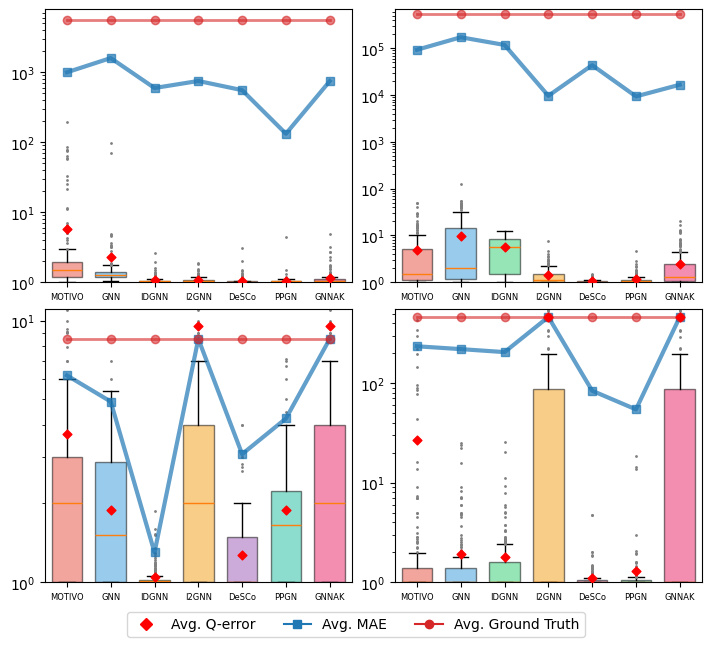

In [72]:
# Define flier properties with smaller markers
flier_props = dict(
    marker='o',
    markerfacecolor='gray',
    markersize=1,
    linestyle='none',
    markeredgecolor='gray'
)

# Create subplots with constrained layout
fig, axes = plt.subplots(2, 2, figsize=(7, 6), constrained_layout=True)
axes = axes.flatten()

for i, (target, ax) in enumerate(zip(selected_targets, axes)):
    results = {}
    gt_target = gt[:, target]
    
    # Collecting results for each algorithm
    for alg in algs:
        pred_graph = get_graph_prediction(dataset_name, alg, target)
        pred_graph = torch.tensor(pred_graph)
        
        # Calculate Q-Error
        qerror = (gt_target + 1) / (pred_graph + 1)
        qerror = torch.where(qerror > 1, qerror, 1 / qerror)
        
        # Calculate MAE
        mae = torch.abs(gt_target - pred_graph)
        
        results[alg] = {'qerror': qerror, 'mae': mae}

    # Prepare data for plotting
    qerror_data = []
    mae_data = []
    gt_data = []
    for method, data in results.items():
        qerror_data.append(data['qerror'].numpy())
        mae_data.append(np.mean(data['mae'].numpy()))
        gt_data.append(np.mean(gt_target.numpy()))
    
    # Plot boxplot for Q-Error with customized flierprops
    bp = ax.boxplot(
        qerror_data,
        positions=range(len(algs)),
        widths=0.7,
        patch_artist=True,
        flierprops=flier_props
    )
    
    # Set box colors
    for patch, color in zip(bp['boxes'], color_palette.values()):
        patch.set_facecolor(color)
        patch.set_alpha(0.5)
    
    # Add mean markers to the boxplot
    means = [np.mean(qerror) for qerror in qerror_data]
    ax.scatter(
        range(len(algs)),
        means,
        color='red',
        marker='D',
        s=20,
        zorder=3,
        label='Q-Error Mean'  # Temporarily adding label (will be handled in the global legend)
    )
    
    ax.set_yscale('log')
    ax.set_ylim(1, 200)
    # ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.grid(False)

    mae_line = ax.plot(
        range(len(algs)),
        mae_data,
        color='#1F77B4',
        marker='s',
        linewidth=3,
        markersize=6,
        alpha=0.7,
        label='MAE'  # Temporarily adding label
    )[0]
    
    gt_line = ax.plot(
        range(len(algs)),
        gt_data,
        color='#D62728',
        marker='o',
        linewidth=2,
        markersize=6,
        alpha=0.6,
        label='Avg. Ground Truth'  # Temporarily adding label
    )[0]

    # set the y-axis limit to 2*Max(mae_data)
    map_i = [5, 4, 1.3, 1.2]
    ax.set_ylim(1,map_i[i]*np.max(mae_data))
    
    # Add pattern inset
    # ax_pattern = ax.inset_axes([0.05, 0.67, 0.25, 0.3])
    # pattern = nx.graph_atlas(pattern_index[target])
    # nx.draw(
    #     pattern,
    #     nx.spring_layout(pattern, seed=0),
    #     ax=ax_pattern,
    #     node_size=20,
    #     with_labels=False
    # )
    # ax_pattern.axis('off')
    
    # Set x-ticks
    ax.set_xticks(range(len(algs)))
    ax.set_xticklabels(algs, fontsize=6, ha='center')
    # ax2.yaxis.set_visible(False)

# Define legend handles (only once)
handles = [
    plt.Line2D(
        [], [],
        color='red', marker='D', linestyle='None',
        markersize=6, label='Avg. Q-error'
    ),
    plt.Line2D(
        [], [],
        color='#1F77B4', marker='s', linestyle='-',
        markersize=6, label='Avg. MAE'
    ),
    plt.Line2D(
        [], [],
        color='#D62728', marker='o', linestyle='-',
        markersize=6, label='Avg. Ground Truth'
    )
]

# Add a single legend to the top of the figure
fig.legend(
    handles=handles,
    loc='upper center',
    ncol=3,
    fontsize=10,
    bbox_to_anchor=(0.5, 0)  # Adjust the y-coordinate as needed
)

# Save the plot
plt.savefig('plots/final/retrain_boxplot.pdf', bbox_inches='tight')

# Display the plot
plt.show()

## 2.4 Different Datasets(target 13)

In [19]:
datasets = ['Set_1', 'Set_2', 'Set_3', 'Set_5']
algs = ['Motivo', 'DeSCo', 'GNN', 'GNNAK', 'IDGNN', 'ESC-GNN', 'I2GNN', 'PPGN']

target = 13
gts = {}
for dataset_name in datasets:
    dataset = torch.load(os.path.join('input', dataset_name, 'dataset.pt'), weights_only=False)['test']
    gt = torch.cat([torch.sum(g.gt_induced_le5[:, target+1], 0).reshape(1, -1) for g in dataset])
    gt = (torch.abs(gt) // 5).reshape(-1)
    gts[dataset_name] = gt

In [20]:
def get_graph_prediction(dataset_name, alg, target):
    try: 
        if alg == 'DeSCo':
            file_path = f'output/{dataset_name}/DeSCo/finetuned/prediction_graph_ordered.csv'
            df = pd.read_csv(file_path, header=0, index_col=0)
            return df.iloc[:, target].values
        elif alg == 'Motivo':
            file_path = f'output/{dataset_name}/MOTIVO/prediction.csv'
            df = pd.read_csv(file_path, header=0, index_col=0)
            return df['AHM'].values
        else:
            file_path = 'output/few_shot_all_graph.json'
            f = json.load(open(file_path, 'r'))
            return f[alg][dataset_name]['pred']
    except:
        return None

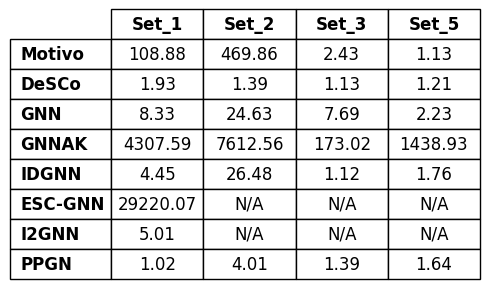

In [21]:
# Initialize a dictionary to store avg_qerrors
avg_qerrors = {alg: [] for alg in algs}

# Populate the avg_qerrors dictionary
for alg in algs:
    for dataset_name in datasets:
        pred_graph = get_graph_prediction(dataset_name, alg, target)
        if pred_graph is not None:
            pred_graph = torch.tensor(pred_graph)
            qerror = (gts[dataset_name] + 1) / (pred_graph + 1)
            qerror = torch.where(qerror > 1, qerror, 1 / qerror)
            avg_qerrors[alg].append(qerror.mean().item())
        else:
            avg_qerrors[alg].append(None)

# Convert to pandas DataFrame for better handling
df = pd.DataFrame(avg_qerrors, index=datasets).T  # Algorithms as rows, Datasets as columns

# Replace None with np.nan for consistent handling of missing data
df = df.replace({None: np.nan})

# Function to format the DataFrame for display
def format_table_data(df):
    """
    Convert the DataFrame into a list of lists with formatted strings.
    Numerical values are formatted to two decimal places.
    Missing values are represented as 'N/A'.
    """
    table_data = []
    for alg in df.index:
        row = []
        for value in df.loc[alg]:
            if pd.isna(value):
                row.append('N/A')
            else:
                row.append(f"{value:.2f}")
        table_data.append(row)
    return table_data

# Prepare the table data
formatted_table = format_table_data(df)

# Start plotting
fig, ax = plt.subplots(figsize=(5, 3))  # Reduced height from (10, 8) to (10, 5)

# Hide axes
ax.axis('off')

# Optional: Adjust subplot parameters to minimize margins
plt.subplots_adjust(left=0.2, right=0.95, top=0.85, bottom=0.15)

# Create the table
table = ax.table(cellText=formatted_table,
                 rowLabels=df.index,
                 colLabels=df.columns,
                 cellLoc='center',
                 loc='center',
                 edges='closed')  # 'closed' ensures that cell borders are drawn

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.0, 1.4)  # Adjusted scaling: horizontal scaling to 1.0, vertical to 1.2

# Set header row and column labels font to bold
for (row, col), cell in table.get_celld().items():
    if row == 0:
        # Column headers
        cell.get_text().set_fontweight('bold')
        cell.set_edgecolor('black')
    if col == -1:
        # Row labels (algorithm names)
        cell.get_text().set_fontweight('bold')
        cell.set_edgecolor('black')
    else:
        cell.set_edgecolor('black')  # Cell borders

# Adjust layout to make sure everything fits without overlap
plt.tight_layout()
# save the plot
plt.savefig('plots/final/few_shot_qerror_t13.pdf', bbox_inches='tight')

# 3. Robustness
## 3.1 Graph-size accuracy
### 3.1.1 Graph-size and density on accuracy

In [14]:
datasets = 'Set_1'
target = 11
pattern_node = 5
algs = ['Motivo', 'DeSCo', 'GNN', 'GNNAK', 'IDGNN', 'ESC-GNN', 'I2GNN', 'PPGN']

In [15]:
def get_size_density(dataset_name):
    file_path = f'input/{dataset_name}/dataset.pt'
    data_list = torch.load(file_path, weights_only=False)['test']
    sizes = [g.num_nodes for g in data_list]
    densities = [g.degree_avg for g in data_list]
    return sizes, densities
def get_graph_qerror(dataset_name, alg, target):
    file_path = f'input/{dataset_name}/dataset.pt'
    data_list = torch.load(file_path, weights_only=False)['test']
    gt = torch.tensor([torch.sum(g.gt_induced_le5[:, target+1])//pattern_node for g in data_list])

    try:
        if alg == 'DeSCo':
            file_path = f'output/prediction_graph_ordered.csv'
            df = pd.read_csv(file_path, header=0, index_col=0)
            pred = df.iloc[:, target].values
            pred = torch.max(torch.tensor(pred), torch.tensor(0))
        elif alg == 'Motivo':
            file_path = f'output/{dataset_name}/MOTIVO/prediction.csv'
            df = pd.read_csv(file_path, header=0, index_col=0)
            pred = df['AHM'].values
            pred = torch.max(torch.tensor(pred), torch.tensor(0))
        else:
            file_path = f'output/graph_error_target11_full_retrain.json'
            f = json.load(open(file_path, 'r'))
            pred = f[alg][dataset_name]['pred']
            pred = torch.tensor(pred)
        qerror = (gt + 1) / (pred + 1)        
        qerror = torch.where(qerror > 1, qerror, 1 / qerror)
        # qerror = torch.log(qerror)
        # normalize the qerror
        # qerror = (qerror - qerror.mean()) / qerror.std()
        return qerror.tolist()
    except:
        return None
def get_size_density_qerror(dataset_name, alg, target):
    sizes, densities = get_size_density(dataset_name)
    qerrors = get_graph_qerror(dataset_name, alg, target)
    return sizes, densities, qerrors

In [16]:
for alg in algs:
    sizes, densities, qerrors = get_size_density_qerror(datasets, alg, target)
    print(f'Avg. Qerror for {alg}: {np.mean(qerrors):.2f}')

Avg. Qerror for Motivo: 23.81
Avg. Qerror for DeSCo: 1.12
Avg. Qerror for GNN: 2.48
Avg. Qerror for GNNAK: 1064.53
Avg. Qerror for IDGNN: 1.31
Avg. Qerror for ESC-GNN: 5350.18
Avg. Qerror for I2GNN: 1063.59
Avg. Qerror for PPGN: 1.03


/tmp/ipykernel_1806863/458460906.py:121: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.95, 0.95])


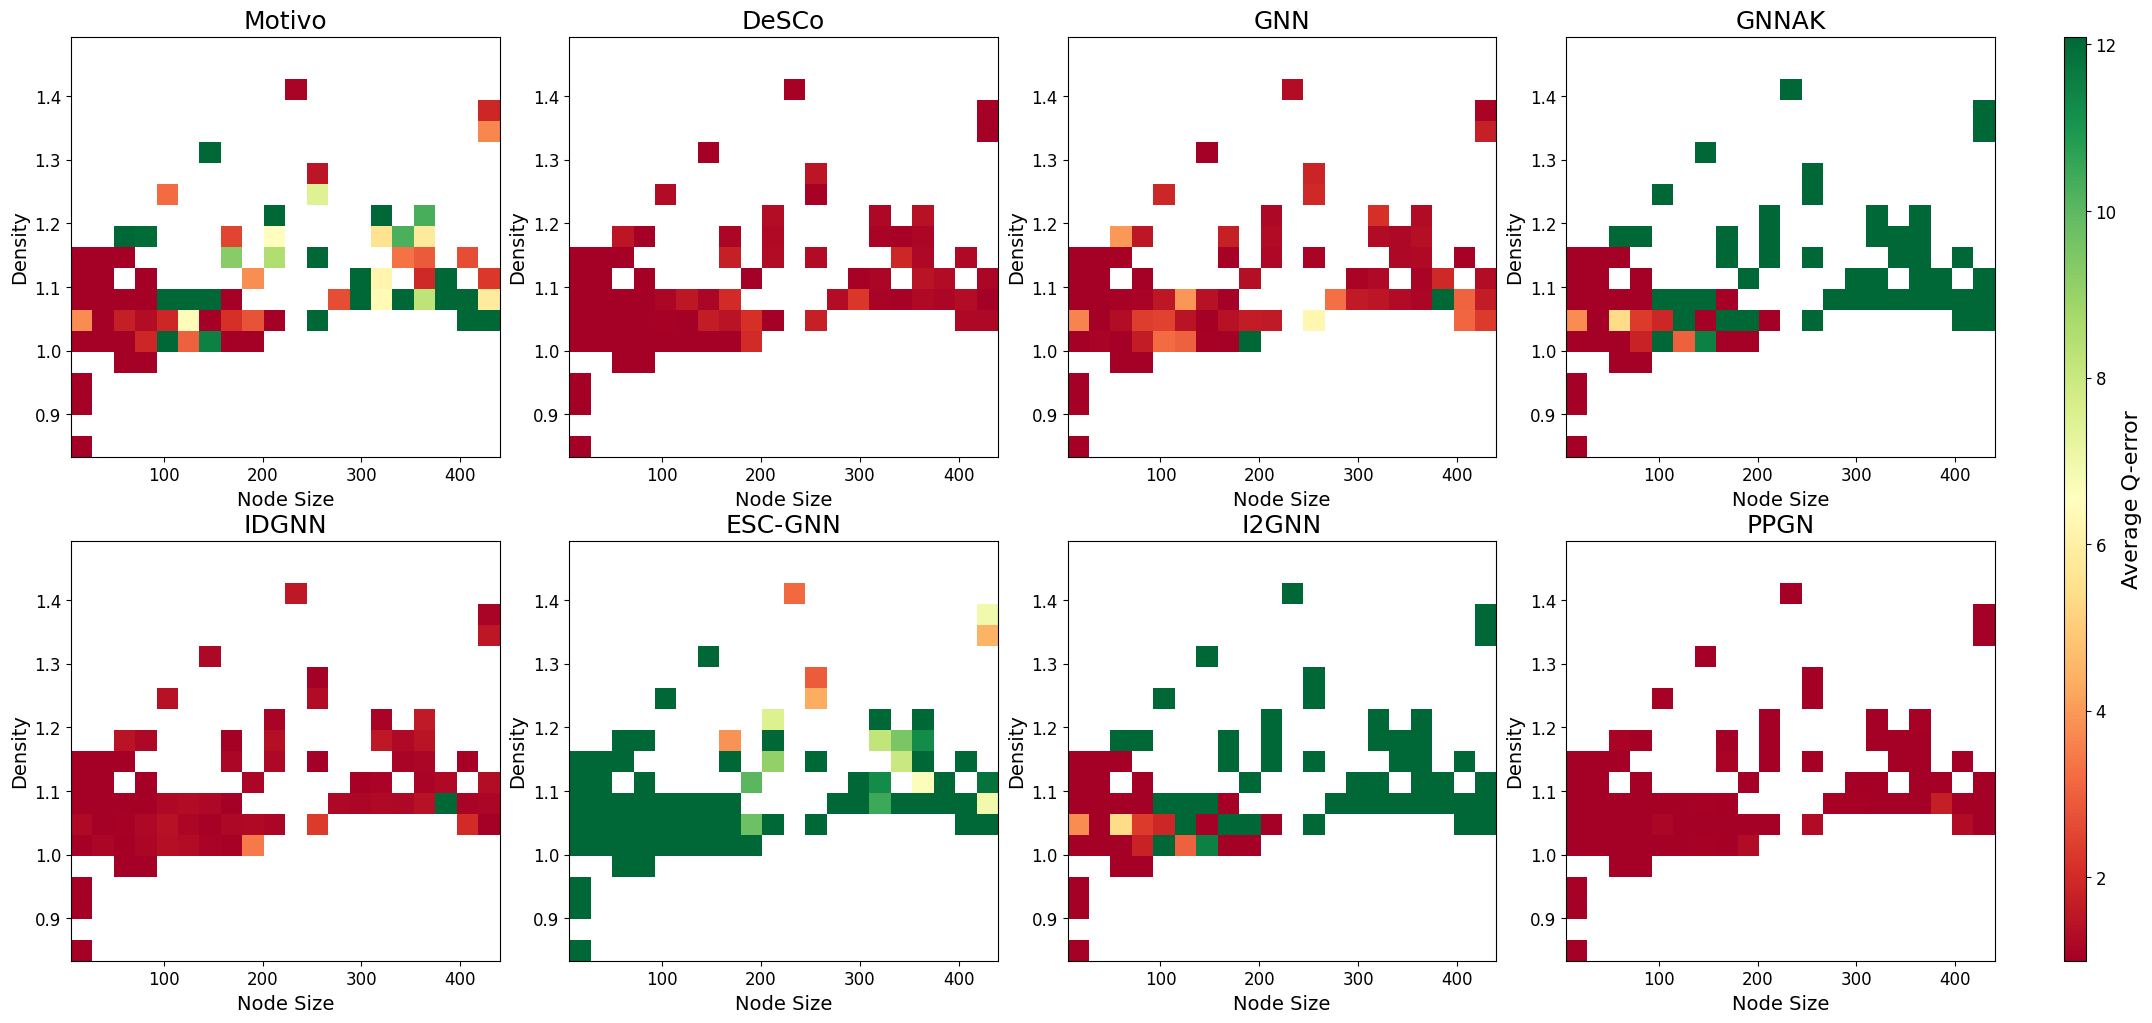

In [24]:
# Start plotting
fig = plt.figure(figsize=(26, 12))
# Create a GridSpec with 2 rows and 5 columns (last column for colorbar)
gs = gridspec.GridSpec(2, 5, width_ratios=[1, 1, 1, 1, 0.05], wspace=0.2, hspace=0.2)

# Define number of bins for graph size and density
bins_size = 20
bins_density = 20

# Initialize vmin and vmax for color normalization
all_qerrors = []
for alg in algs:
    _, _, qerrors = get_size_density_qerror(datasets, alg, target)
    if qerrors:
        all_qerrors.extend(qerrors)

if all_qerrors:
    # Define vmin and vmax based on percentiles to minimize outlier impact
    lower_percentile = np.percentile(all_qerrors, 0)
    upper_percentile = np.percentile(all_qerrors, 80)
    vmin = max(1, lower_percentile)    # Since Q-error >=1
    vmax = upper_percentile
else:
    vmin, vmax = 1, 10  # Default values if no Q-errors are available

# Iterate through each algorithm and plot its heatmap
all_meshes = []  # To store mesh objects for the colorbar
for i, alg in enumerate(algs):
    row = i // 4
    col = i % 4
    ax = fig.add_subplot(gs[row, col])
    sizes, densities, qerrors = get_size_density_qerror(datasets, alg, target)
    
    if qerrors is None or len(qerrors) == 0:
        ax.set_title(f"{alg}\nNo Q-error Data", fontsize=16)
        # ax.axis('off')  # Hide axes if no data
        continue
    
    sizes = np.array(sizes)
    densities = np.array(densities)
    qerrors = np.array(qerrors)
    
    # Define bin edges based on data
    size_min, size_max = sizes.min(), sizes.max()
    density_min, density_max = densities.min(), densities.max()
    
    size_bins = np.linspace(size_min, size_max, bins_size + 1)
    density_bins = np.linspace(density_min, density_max, bins_density + 1)
    
    # Digitize node sizes and densities to find bin indices
    size_indices = np.digitize(sizes, size_bins) - 1  # Bin indices for sizes
    density_indices = np.digitize(densities, density_bins) - 1  # Bin indices for densities
    
    # Initialize arrays to hold sum of Q-errors and counts per bin
    qerror_sum = np.zeros((bins_density, bins_size))  # Rows: density, Columns: size
    counts = np.zeros((bins_density, bins_size))
    
    # Accumulate Q-errors and counts using vectorized operations
    valid_mask = (
        (size_indices >= 0) & (size_indices < bins_size) &
        (density_indices >= 0) & (density_indices < bins_density)
    )
    size_indices_valid = size_indices[valid_mask]
    density_indices_valid = density_indices[valid_mask]
    qerrors_valid = qerrors[valid_mask]
    
    # Use numpy's add.at for efficient accumulation
    np.add.at(qerror_sum, (density_indices_valid, size_indices_valid), qerrors_valid)
    np.add.at(counts, (density_indices_valid, size_indices_valid), 1)
    
    # Calculate average Q-error per bin
    with np.errstate(invalid='ignore', divide='ignore'):
        avg_qerror = qerror_sum / counts
    avg_qerror = np.ma.masked_where(counts == 0, avg_qerror)  # Mask bins with no data
    
    # Create meshgrid for pcolormesh with Size on X-axis and Density on Y-axis
    SIZE_bins, DENSITY_bins = np.meshgrid(size_bins, density_bins)
    
    # Plot the average Q-error heatmap using 'RdYlGn' colormap
    mesh = ax.pcolormesh(SIZE_bins, DENSITY_bins, avg_qerror, cmap='RdYlGn',
                         vmin=vmin, vmax=vmax, shading='auto')
    all_meshes.append(mesh)  # Store mesh for colorbar
    
    # Set axis labels and title
    ax.set_xlabel('Node Size', fontsize=14)
    ax.set_ylabel('Density', fontsize=14)
    ax.set_title(alg, fontsize=18)
    
    # Set axis limits
    ax.set_xlim(size_min, size_max)
    ax.set_ylim(density_min, density_max)
    ax.grid(False)
    
    # Improve tick label sizes
    ax.tick_params(axis='both', which='major', labelsize=12)

# ---------- Add a Single Colorbar on the Right ----------
# Use the last GridSpec column for the colorbar
cbar_ax = fig.add_subplot(gs[:, -1])  # Span all rows

if all_meshes:
    # Assuming all meshes use the same colormap and normalization
    # Use the first mesh to create the colorbar
    cbar = fig.colorbar(all_meshes[0], cax=cbar_ax, orientation='vertical')
    cbar.set_label('Average Q-error', fontsize=16)
    cbar.ax.tick_params(labelsize=12)
else:
    # Create a dummy colorbar if no data was available
    norm = Normalize(vmin=1, vmax=10)
    sm = plt.cm.ScalarMappable(cmap='RdYlGn', norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical')
    cbar.set_label('Average Q-error', fontsize=16)
    cbar.ax.tick_params(labelsize=12)

# ---------- Add Main Title and Adjust Layout ----------
# Add a main title for the entire figure
# fig.suptitle('Q-error Heatmaps by Algorithm (Color Indicates Average Q-error)', fontsize=22, y=1.02)

# Adjust layout to accommodate the colorbar and main title
plt.tight_layout(rect=[0, 0, 0.95, 0.95])

# Display the plot
# save the plot
plt.savefig('plots/final/heatmap_graph_t11.pdf', bbox_inches='tight', format='pdf')
plt.show()

### 3.1.2 Pattern Size affect

In [ ]:
dataset_name = 'Set_1'
targets = [0, 3, 10]
num_nodes = [3, 4, 5]
algs = ['Motivo', 'DeSCo', 'GNN', 'GNNAK', 'IDGNN', 'ESC-GNN', 'I2GNN', 'PPGN']
dataset = torch.load(os.path.join('input', dataset_name, 'dataset.pt'), weights_only=False)['test']
gts = []
for idx, target in enumerate(targets):
    gt = [(torch.sum(g.gt_induced_le5[:, target+1])//num_nodes[idx]).item() for g in dataset]
    gts.append(gt)

In [ ]:
def get_qerror_mae(dataset_name, alg, targets):
    try:
        if alg == 'DeSCo' or alg == 'Motivo':
            if alg == 'DeSCo':
                file_path = f'output/{dataset_name}/DeSCo/finetuned/prediction_graph_ordered.csv'
            else:
                file_path = f'output/{dataset_name}/MOTIVO/prediction.csv'
            df = pd.read_csv(file_path, header=0, index_col=0)
            pred = df.iloc[:, targets].values
            pred = torch.tensor(pred)
        else:
            file_path = f'output/few_shot_star_graph.json'
            f = json.load(open(file_path, 'r'))
            pred = []
            for target in targets:
                pred.append(f[alg][dataset_name][str(target)]['pred'])
            pred = torch.tensor(pred).T

        qerrors = []
        maes = []
        for idx, target in enumerate(targets):
            gt = torch.tensor(gts[idx])
            if pred is not None and idx < pred.shape[1]:
                pred_target = pred[:, idx]
                # Avoid division by zero by adding 1 as per your original code
                qerror = (gt + 1) / (pred_target + 1)
                qerror = torch.where(qerror > 1, qerror, 1 / qerror)
                mae = torch.abs(gt - pred_target).to(torch.float32)
                qerrors.append(qerror.mean().item())
                maes.append(mae.mean().item())
            else:
                qerrors.append(np.nan)
                maes.append(np.nan)
        
        return qerrors, maes
    except:
        return [np.nan] * len(targets), [np.nan] * len(targets)

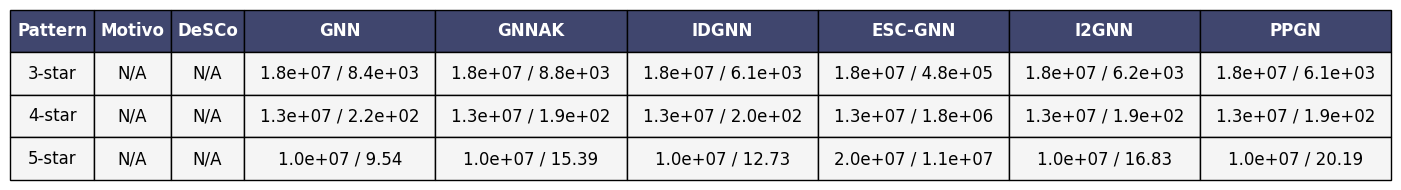

In [ ]:
# Initialize a DataFrame to store MAE and Qerror
data = {'Pattern': ['3-star', '4-star', '5-star']}
for alg in algs:
    qerrors, maes = get_qerror_mae(dataset_name, alg, targets)
    # Combine MAE and Qerror into a single string per cell
    combined = []
    for mae, q in zip(maes, qerrors):
        if np.isnan(mae) or np.isnan(q):
            combined.append("N/A")
        else:
            # Format numbers with two decimals and scientific notation if necessary
            def format_value(x):
                if abs(x) >= 1e2 or (abs(x) < 1e-2 and x != 0):
                    return f"{x:.1e}"
                else:
                    return f"{x:.2f}"
            formatted_mae = format_value(mae)
            formatted_q = format_value(q)
            combined.append(f"{formatted_mae} / {formatted_q}")
    data[alg] = combined

df_table = pd.DataFrame(data)

# Create a Matplotlib figure and axis
fig, ax = plt.subplots(figsize=(14, 2))  # Adjust figsize as needed

# Hide axes
ax.axis('off')
ax.axis('tight')

# Create the table
the_table = ax.table(cellText=df_table.values,
                     colLabels=df_table.columns,
                     cellLoc='center',
                     loc='center')

# Styling the table
the_table.auto_set_font_size(False)
the_table.set_fontsize(12)
the_table.auto_set_column_width(col=list(range(len(df_table.columns))))

# Add borders to cells and set colors
for (i, j), cell in the_table.get_celld().items():
    if i == 0:
        cell.set_facecolor("#40466e")  # Header background color
        cell.set_text_props(color='w', weight='bold')  # Header text color and weight
    else:
        cell.set_facecolor("#F5F5F5")  # Body background color
    cell.set_edgecolor('black')  # Cell borders

# Adjust layout and scale
the_table.scale(1, 2.4)  # Scale table to fit the figure

# Adjust layout
plt.tight_layout()

# Display the table
# save the plot
plt.savefig('plots/final/star_patterns.pdf', format='pdf', bbox_inches='tight')
plt.show()

## 3.2 Node-size accuracy
### 3.2.1 Degree and clustering coefficient influence on accuracy

In [28]:
datasets = 'Set_1'
target = 11
algs = ['DeSCo', 'GNN', 'GNNAK', 'IDGNN', 'ESC-GNN', 'I2GNN', 'PPGN']
column_exchange = [0, 1, 3, 2, 5, 4, 6, 7, 10, 9, 8, 12, 13, 11, 15, 14, 16, 18, 17, 20, 19, 22, 21, 23, 24, 25, 26, 27, 28]

In [29]:
def get_degree_cc(dataset_name):
    file_path = f'input/{dataset_name}/dataset.pt'
    data_list = torch.load(file_path, weights_only=False)['test']
    degrees = []
    ccs = []
    for data in data_list:
        # get the degrees and clustering coefficients of the nodes
        G = to_networkx(data, to_undirected=True)
        degrees_dict = dict(G.degree())
        degree = [degrees_dict[i] for i in range(data.num_nodes)]
        degrees.extend(degree)
        clustering_dict = nx.clustering(G)
        cc = [clustering_dict[i] for i in range(data.num_nodes)]
        ccs.extend(cc)
    return degrees, ccs
def get_node_qerror(dataset_name, alg, target):
    file_path = f'input/{dataset_name}/dataset.pt'
    data_list = torch.load(file_path, weights_only=False)['test']
    try:
        if alg == 'DeSCo':
            gt = torch.cat([g.gt_induced_le5_desco[:, column_exchange[target]] for g in data_list])
            file_path = f'output/prediction_node_ordered.csv'
            df = pd.read_csv(file_path, header=0, index_col=0)
            pred = df.iloc[:, target].values
            pred = torch.max(torch.tensor(pred), torch.tensor(0))
            qerror = (gt + 1) / (pred + 1)        
            qerror = torch.where(qerror > 1, qerror, 1 / qerror)
            # qerror = torch.log(qerror)
            # normalize the qerror
            # qerror = (qerror - qerror.mean()) / qerror.std()
            return qerror.tolist()
        else:
            file_path = 'output/node_error_target11_full_retrain.json'
            f = json.load(open(file_path, 'r'))
            pred = f[alg][dataset_name]['pred']
            gt = torch.cat([g.gt_induced_le5[:, target+1] for g in data_list])
            pred = torch.tensor(pred)
            qerror = (gt + 1) / (pred + 1)
            qerror = torch.where(qerror > 1, qerror, 1 / qerror)
            return qerror.tolist()
    except:
        return None
def get_deg_cc_pred(dataset_name, alg, target):
    degrees, ccs = get_degree_cc(dataset_name)
    qerrors = get_node_qerror(dataset_name, alg, target)
    return degrees, ccs, qerrors

In [30]:
# use x-axis as degrees and y-axis as clustering coefficients, draw the qerrors as the color of the points. Better to split the plot to grids and color the grids according to the average qerror in the grid.
# make a plot consisting of 2*4 subplots, the first 7 is for each alg, the last one is for the legend of the colorbar

/tmp/ipykernel_1806863/1782559190.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 1])


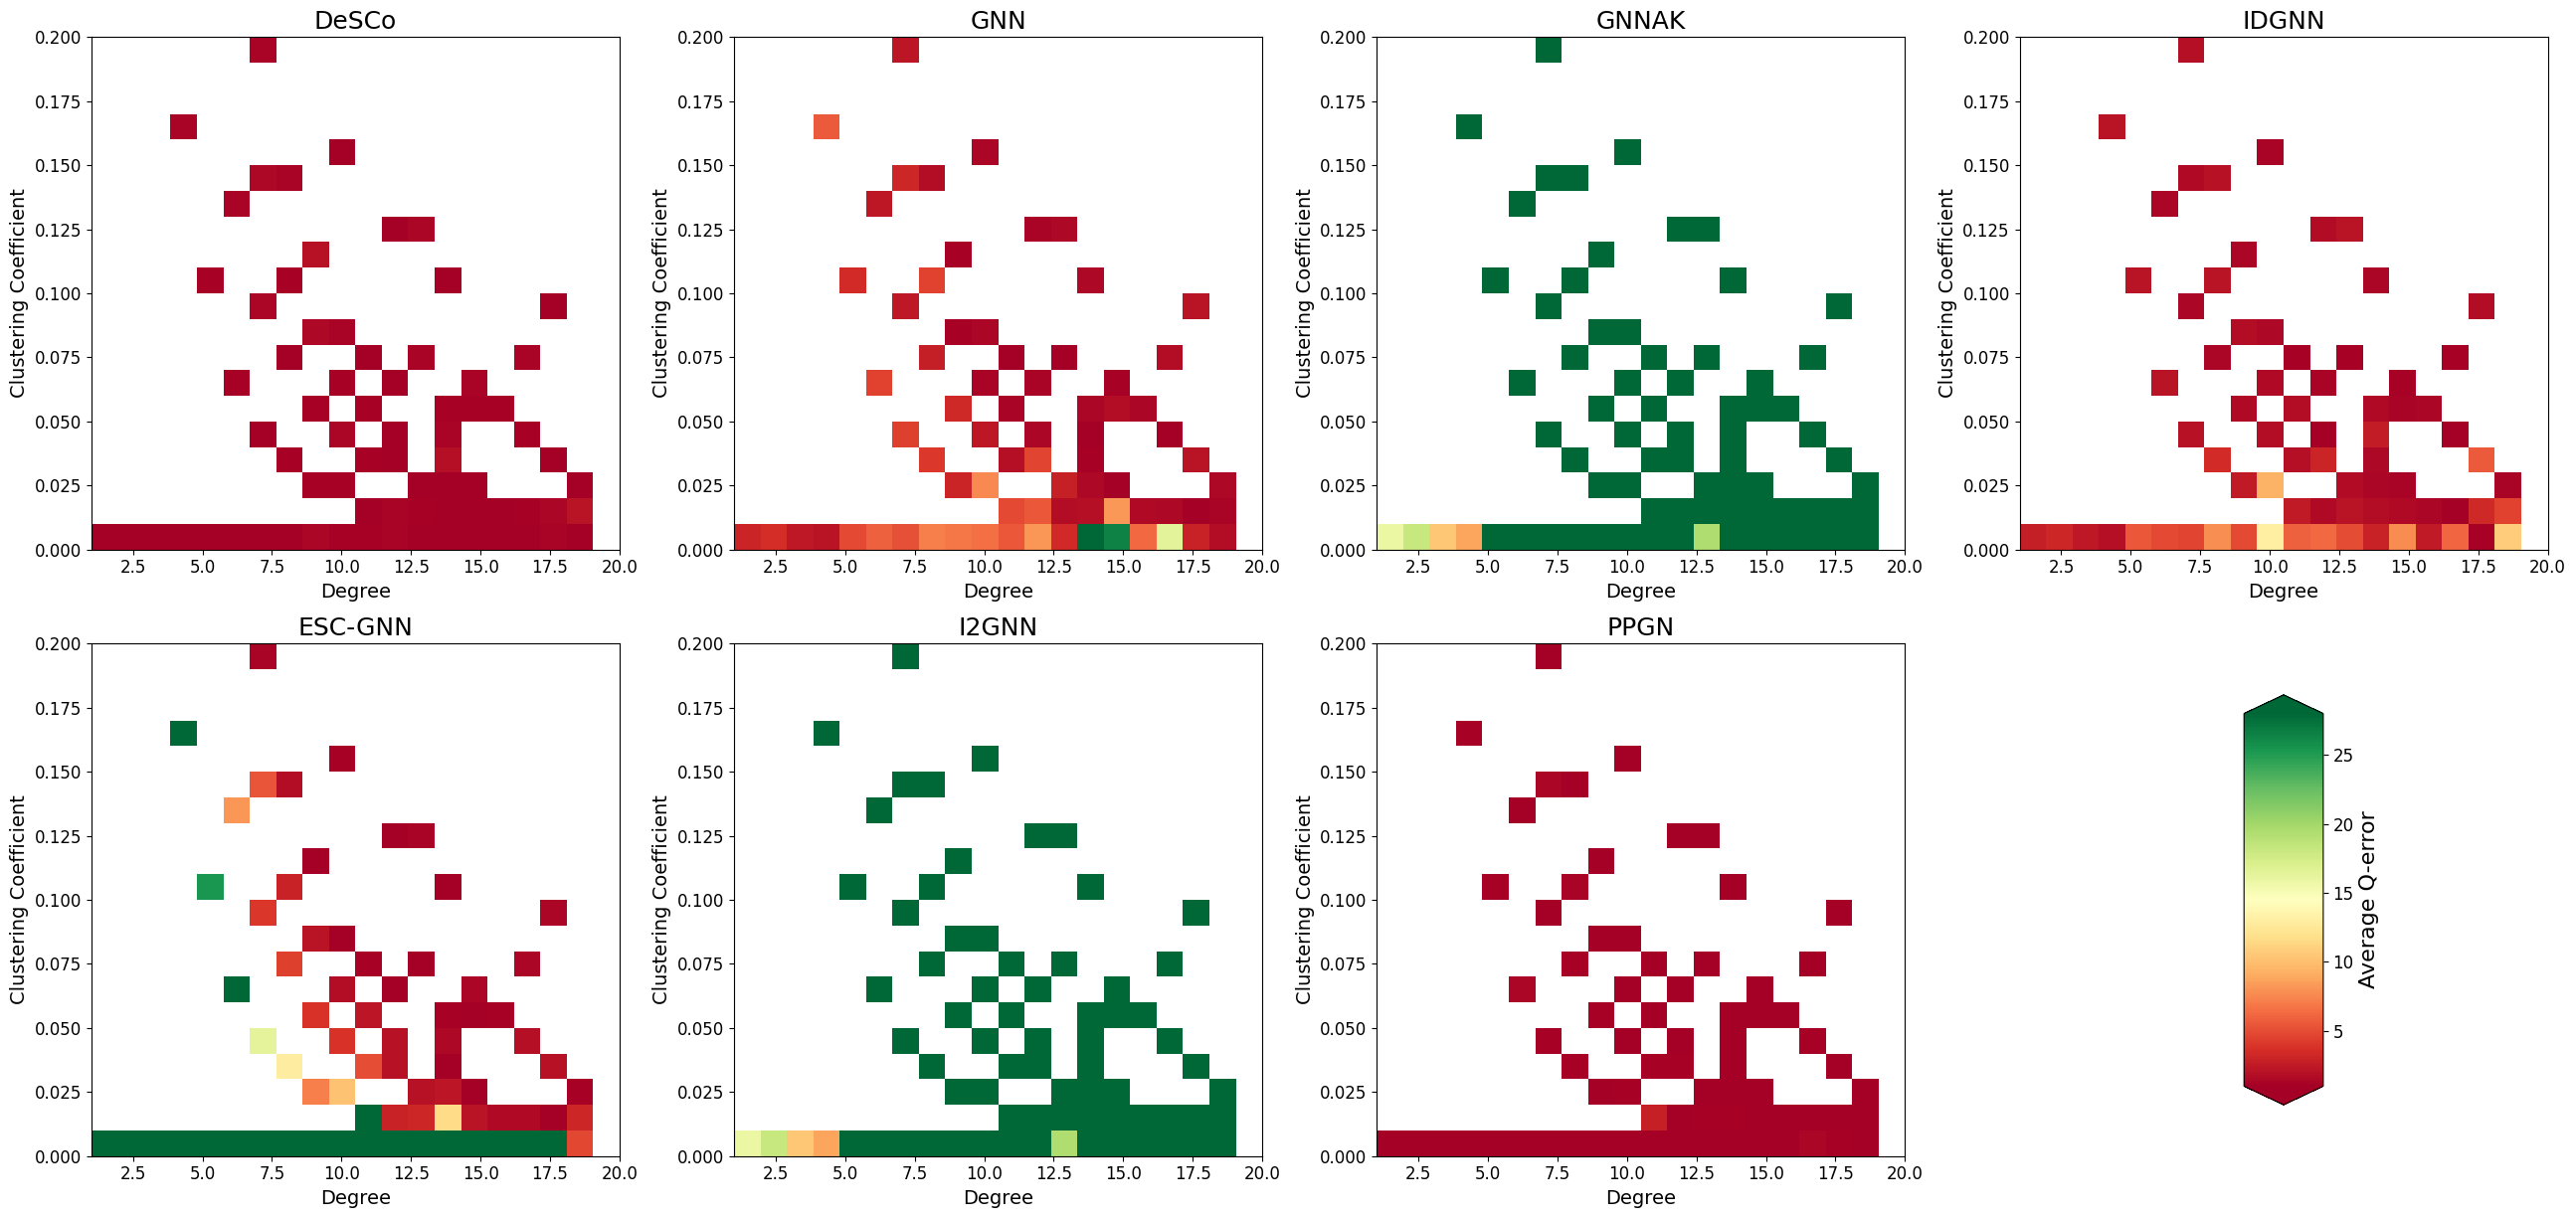

In [31]:
# Start plotting
fig, axes = plt.subplots(2, 4, figsize=(26, 12.35))  # 2x4 grid
axes = axes.flatten()

# Define number of bins for degree and clustering coefficient
bins_degree = 20
bins_cc = 20

# Collect all qerrors across all algorithms for global color scaling
all_qerrors = []
for alg in algs:
    degrees, ccs, qerrors = get_deg_cc_pred(datasets, alg, target)
    if qerrors:
        all_qerrors.extend(qerrors)

if all_qerrors:
    # Define vmin and vmax based on percentiles to minimize outlier impact
    lower_percentile = np.percentile(all_qerrors, 0)
    upper_percentile = np.percentile(all_qerrors, 83)
    vmin = max(1, lower_percentile)    # Since Q-error >=1
    vmax = upper_percentile
else:
    vmin, vmax = 1, 10  # Default values if no Q-errors are available

# Iterate through each algorithm and plot its heatmap
for i, alg in enumerate(algs):
    ax = axes[i]
    degrees, ccs, qerrors = get_deg_cc_pred(datasets, alg, target)
    
    if qerrors is None or len(qerrors) == 0:
        ax.set_title(f"{alg}\nNo Q-error Data", fontsize=16)
        # ax.axis('off')  # Hide axes if no data
        continue
    
    degrees = np.array(degrees)
    ccs = np.array(ccs)
    qerrors = np.array(qerrors)
    
    # Define bin edges based on data
    # degree_min, degree_max = degrees.min(), degrees.max()
    degree_min, degree_max = degrees.min(), 20
    # cc_min, cc_max = ccs.min(), ccs.max()
    cc_min, cc_max = ccs.min(), 0.2
    
    degree_bins = np.linspace(degree_min, degree_max, bins_degree + 1)
    cc_bins = np.linspace(cc_min, cc_max, bins_cc + 1)
    
    # Digitize degrees and clustering coefficients to find bin indices
    degree_indices = np.digitize(degrees, degree_bins) - 1  # Bin indices for degrees
    cc_indices = np.digitize(ccs, cc_bins) - 1            # Bin indices for clustering coefficients
    
    # Initialize arrays to hold sum of Q-errors and counts per bin
    qerror_sum = np.zeros((bins_cc, bins_degree))  # Rows: CC bins, Columns: Degree bins
    counts = np.zeros((bins_cc, bins_degree))
    
    # Valid data mask
    valid_mask = (
        (degree_indices >= 0) & (degree_indices < bins_degree) &
        (cc_indices >= 0) & (cc_indices < bins_cc)
    )
    degree_indices_valid = degree_indices[valid_mask]
    cc_indices_valid = cc_indices[valid_mask]
    qerrors_valid = qerrors[valid_mask]
    
    # Accumulate Q-errors and counts using vectorized operations for efficiency
    np.add.at(qerror_sum, (cc_indices_valid, degree_indices_valid), qerrors_valid)
    np.add.at(counts, (cc_indices_valid, degree_indices_valid), 1)
    
    # Calculate average Q-error per bin
    with np.errstate(invalid='ignore', divide='ignore'):
        avg_qerror = qerror_sum / counts
    avg_qerror = np.ma.masked_where(counts == 0, avg_qerror)  # Mask bins with no data
    
    # Create meshgrid for pcolormesh with Degree on X-axis and CC on Y-axis
    DEG_bins, CC_bins = np.meshgrid(degree_bins, cc_bins)
    
    # Plot the average Q-error heatmap using 'RdYlGn' colormap
    mesh = ax.pcolormesh(DEG_bins, CC_bins, avg_qerror, cmap='RdYlGn',
                         vmin=vmin, vmax=vmax, shading='auto')
    
    # Set axis labels and title
    ax.set_xlabel('Degree', fontsize=14)
    ax.set_ylabel('Clustering Coefficient', fontsize=14)
    ax.set_title(alg, fontsize=18)
    
    # Set axis limits
    ax.set_xlim(degree_min, degree_max)
    ax.set_ylim(cc_min, cc_max)
    
    # Improve tick label sizes
    ax.tick_params(axis='both', which='major', labelsize=12)

# ------------ Configure the Last Subplot for Colorbar ------------

# The last subplot is reserved for the colorbar
cbar_ax = axes[-1]
cbar_ax.axis('off')  # Hide the axes

# Create an inset axes within the last subplot for the colorbar
inset_width = "15%"    # Width of the colorbar relative to the last subplot
inset_height = "80%"  # Height of the colorbar relative to the last subplot
cax = inset_axes(cbar_ax, width=inset_width, height=inset_height, loc='center')

# Add the colorbar to the inset axes
if 'mesh' in locals():
    # Create a colorbar linked to the last mesh plot
    cbar = fig.colorbar(mesh, cax=cax, orientation='vertical', extend='both')
    cbar.set_label('Average Q-error', fontsize=16)
    cbar.ax.tick_params(labelsize=12)
else:
    # Create a dummy colorbar if no data was plotted
    sm = plt.cm.ScalarMappable(cmap='RdYlGn', norm=Normalize(vmin=1, vmax=10))
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
    cbar.set_label('Average Q-error', fontsize=16)
    cbar.ax.tick_params(labelsize=12)

# ------------ Add Main Title and Adjust Layout ------------

# Add a main title for the entire figure
# fig.suptitle('Q-error Heatmaps by Algorithm (Color Indicates Average Q-error)', fontsize=22, y=1.02)

# Adjust layout to accommodate the colorbar and main title
plt.tight_layout(rect=[0, 0, 1, 1])

# Display the plot
# save the plot
plt.savefig('plots/final/heatmap_node_t11.pdf', format='pdf')
plt.show()

## 3.3 Epoch Trend

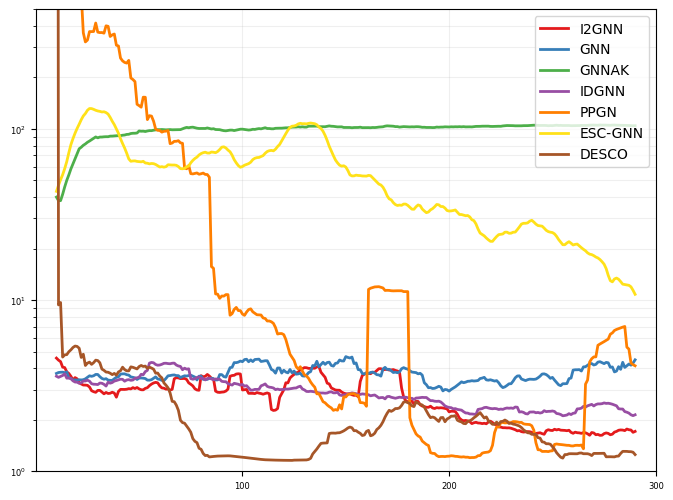

In [42]:
def inspect_and_clean_data(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    cleaned_data = {}
    for alg, targets in data.items():
        if '11' in targets:
            metrics = targets['11']
            cleaned_data[alg] = {}
            for metric, values in metrics.items():
                if isinstance(values, list):
                    cleaned_values = [float(v) if isinstance(v, (int, float)) else np.nan for v in values]
                    if alg == 'ESC-GNN':
                        cleaned_values = [v / 10000 for v in cleaned_values]
                    elif alg == 'GNNAK':
                        cleaned_values = [v / 10 for v in cleaned_values]
                    cleaned_data[alg][metric] = cleaned_values
                else:
                    cleaned_value = float(values) if isinstance(values, (int, float)) else np.nan
                    if alg == 'ESC-GNN':
                        cleaned_value /= 50
                    cleaned_data[alg][metric] = [cleaned_value] * 300
    return cleaned_data

def prepare_dataframe(data, metric):
    df = pd.DataFrame()
    for alg, metrics in data.items():
        df[alg] = pd.Series(metrics[metric])
    return df

def smooth_data(df, window=20):
    return df.rolling(window=window, center=True).mean()

def plot_metric(df, metric_name, smoothed_df):
    plt.figure(figsize=(8, 6))
    # sns.set_style("whitegrid")
    
    # Define a more distinguishable color palette
    colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffe119', '#a65628', '#FFD300']
    
    for idx, column in enumerate(df.columns):
        color = colors[idx % len(colors)]
        # plt.plot(df.index, df[column], color=color, linewidth=1, alpha=0.3)
        plt.plot(smoothed_df.index, smoothed_df[column], color=color, linewidth=2, label=column)
    
    title = f'{metric_name} Over Epochs for Target 11 (Smoothed)'
    if 'ESC-GNN' in df.columns:
        title += '\nESC-GNN values divided by 50'
    # plt.title(title, fontsize=24, fontweight='bold')
    # plt.xlabel('Epochs', fontsize=18)
    # plt.ylabel(metric_name, fontsize=18)
    plt.yscale('log')
    plt.xlim(0, 300)
    
    # Adjust y-axis limits to include all data except DESCO
    # df_without_desco = df.drop('DESCO', axis=1, errors='ignore')
    # plt.ylim(df_without_desco.min().min() * 0.9, df_without_desco.max().max() * 1.1)
    plt.ylim(1, 500)

    plt.xticks([100, 200, 300], fontsize=6)
    plt.yticks(fontsize=6)
    
    plt.legend(fontsize=10, loc='upper right')
    
    plt.grid(True, which="both", ls="-", alpha=0.2)
    # plt.grid(False)
    # plt.tight_layout()
    plt.savefig(f'plots/final/qerror_trend_t11.pdf', bbox_inches='tight')
    plt.show()

# File path
file_path = '/home/zxj/Dev/MLSC/output/graph_error_per_epoch.json'

# Inspect and clean data
cleaned_data = inspect_and_clean_data(file_path)

# Prepare DataFrames
df_qerror = prepare_dataframe(cleaned_data, 'q_error')

# Smooth data
smoothed_df_qerror = smooth_data(df_qerror)

# Plot Q-Error
plot_metric(df_qerror, 'Q-Error', smoothed_df_qerror)

## 3.4.1 Algo Scatter

In [33]:
algs = ['DeSCo', 'GNN', 'IDGNN', 'ESC-GNN', 'I2GNN', 'PPGN']

def plot_predictions_vs_ground_truth_subplot(predictions, ground_truth, 
                                            ax_joint, ax_marg_x, ax_marg_y, alg_name):

    # Scatter plot on the joint axes
    sc = ax_joint.scatter(ground_truth, predictions, 
                          c='#3182bd', alpha=0.8, s=20, 
                          edgecolors='none', label=alg_name)

    # KDE plots on marginal axes
    sns.kdeplot(x=ground_truth, ax=ax_marg_x, color="blue", fill=True)
    sns.kdeplot(y=predictions, ax=ax_marg_y, color="orange", fill=True)

    # Set log scale for marginal plots
    ax_marg_x.set_yscale('log')
    ax_marg_y.set_xscale('log')

    # Custom log locator to avoid overflow
    locmaj = LogLocator(base=2, numticks=10)
    locminor = LogLocator(base=2, subs=np.arange(2, 10) * 0.1, numticks=10)

    ax_marg_x.yaxis.set_major_locator(locmaj)
    ax_marg_y.xaxis.set_major_locator(locmaj)
    ax_marg_x.yaxis.set_minor_locator(locminor)
    ax_marg_y.xaxis.set_minor_locator(locminor)

    ax_marg_x.yaxis.set_major_formatter(NullFormatter())
    ax_marg_y.xaxis.set_major_formatter(NullFormatter())

    # Calculate the range for the x=y and regression lines
    min_val = min(ground_truth.min(), predictions.min())
    max_val = max(ground_truth.max(), predictions.max())
    margin = (max_val - min_val) * 0.05

    # Plot x=y line
    ax_joint.plot([min_val, max_val], [min_val, max_val], 
                 color='#000', linestyle='--', 
                 label='x=y Line', linewidth=3)

    # Fit and plot regression line
    slope, intercept, r_value, _, _ = stats.linregress(ground_truth, predictions)
    reg_line = slope * np.array([min_val, max_val]) + intercept
    ax_joint.plot([min_val, max_val], reg_line, 
                 color='#a10000', linestyle='-', 
                 label=f'Regression Line', linewidth=3)

    ax_joint.legend(fontsize=12, loc='upper left')
    # ax_joint.grid(True, linestyle='--', alpha=0.3)
    ax_marg_x.grid(False)
    ax_marg_y.grid(False)

    # Set aspect ratio to equal for a square plot
    ax_joint.set_aspect('equal')

    # Adjust plot limits to include all points with margin
    ax_joint.set_xlim(min_val - margin, max_val + margin)
    ax_joint.set_ylim(min_val - margin, max_val + margin)

    # Improve tick label visibility
    ax_joint.tick_params(axis='both', which='major', labelsize=8)
    # ax_marg_x.tick_params(axis='both', which='major', labelsize=0, labelbottom=False)
    # ax_marg_y.tick_params(axis='both', which='major', labelsize=0, labelleft=False)

        # Remove tick labels on marginal axes
    # For ax_marg_x (top), hide x-axis tick labels
    ax_marg_x.tick_params(axis='x', which='both', labelbottom=False, labelsize=0)
    # Optionally, remove y-axis tick labels if they are not needed
    ax_marg_x.tick_params(axis='y', which='both', labelleft=False, labelsize=0)

    # For ax_marg_y (right), hide y-axis tick labels
    ax_marg_y.tick_params(axis='y', which='both', labelleft=False, labelsize=0)
    # Optionally, remove x-axis tick labels if they are not needed
    ax_marg_y.tick_params(axis='x', which='both', labelbottom=False, labelsize=0)

    # Remove axis labels for marginal axes
    ax_marg_x.set_xlabel('')
    ax_marg_x.set_ylabel('')
    ax_marg_y.set_xlabel('')
    ax_marg_y.set_ylabel('')

    # Remove all spines from a specific Axes
    sns.despine(ax=ax_marg_x, top=True, right=True, left=True, bottom=True)
    sns.despine(ax=ax_marg_y, top=True, right=True, left=True, bottom=True)

def create_jointplot_grid():
    # Create the main figure
    fig = plt.figure(figsize=(18, 12))
    gs = GridSpec(2, 3, figure=fig, wspace=0.1, hspace=0.1)

    # Iterate through each subplot position
    for idx, alg in enumerate(algs):
        
        if alg == 'DeSCo':
            json_file = 'output/Set_1/DeSCo/finetuned/prediction_node_ordered.csv'
            df = pd.read_csv(json_file, header=0, index_col=0)
            predictions = df.iloc[:, 11].values
            predictions = np.maximum(predictions, 0).astype(np.float64)
            gt_path = 'input/Set_1/dataset.pt'
            data_list = torch.load(gt_path, weights_only=False)['test']
            ground_truth = torch.cat([g.gt_induced_le5_desco[:, 12] for g in data_list]).numpy()
        else:
            json_file = 'output/few_shot_target_11_node.json'
            f = json.load(open(json_file, 'r'))
            predictions = f[alg]['Set_1']['pred']
            predictions = np.maximum(predictions, 0).astype(np.float64)
            ground_truth = f[alg]['Set_1']['gt']
            ground_truth = np.array(ground_truth).astype(np.float64)


        # Define the axes for joint and marginals
        ax_joint = fig.add_subplot(gs[idx//3, idx%3])

        # Create divider for marginal axes
        divider = make_axes_locatable(ax_joint)
        ax_marg_x = divider.append_axes("top", size="15%", pad=0.0)
        ax_marg_y = divider.append_axes("right", size="15%", pad=0.0)

        plot_predictions_vs_ground_truth_subplot(predictions, ground_truth, 
                                                    ax_joint, ax_marg_x, ax_marg_y, alg)

    # Set the overall title
    # fig.suptitle('Predictions vs Ground Truth - 2x4 Grid of Subplots', fontsize=16, fontweight='bold')
    # save the plot
    plt.savefig('plots/final/scatter_plot_t11.pdf', format='pdf', bbox_inches='tight')
    plt.savefig('plots/final/scatter_plot_t11.png', format='png', bbox_inches='tight', dpi=300)


    plt.show()

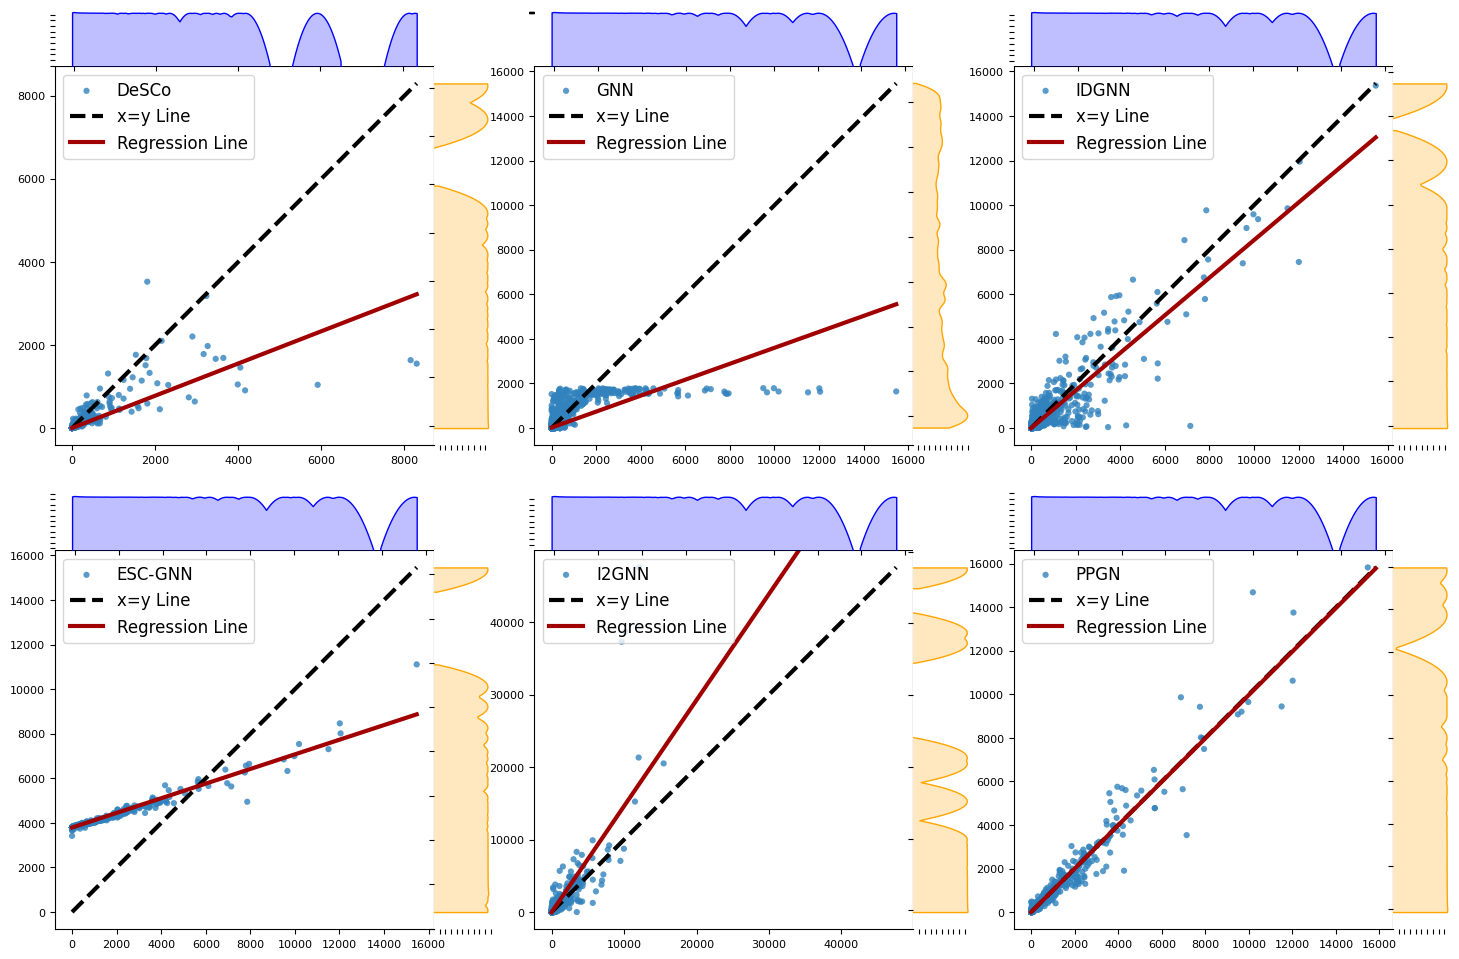

In [34]:
create_jointplot_grid()

## 3.4.2 ESC-GNN Scatter

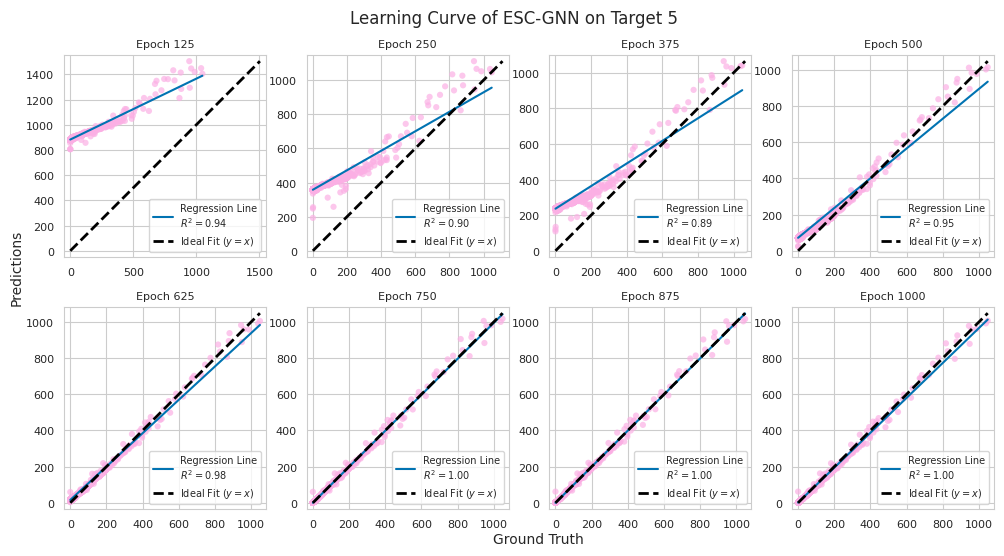

In [35]:
def plot_predictions_vs_ground_truth(ax, json_file_path, epoch):
    # Load data
    with open(json_file_path, 'r') as file:
        data = json.load(file)
    predictions = np.array(data['predictions'])
    ground_truth = np.array(data['ground_truth'])

    # Scatter plot
    ax.scatter(
        ground_truth, predictions,
        c='C6', alpha=0.69, s=20, edgecolors='none'
    )
    
    # Regression line
    slope, intercept, r_value, _, _ = stats.linregress(ground_truth, predictions)
    x_reg = np.linspace(ground_truth.min(), ground_truth.max(), 100)
    y_reg = slope * x_reg + intercept
    ax.plot(
        x_reg, y_reg, color='C0', linestyle='-', linewidth=1.5,
        label=f'Regression Line\n$R^2 = {r_value**2:.2f}$'
    )

    # x=y line
    min_val = min(ground_truth.min(), predictions.min())
    max_val = max(ground_truth.max(), predictions.max())
    ax.plot(
        [min_val, max_val], [min_val, max_val],
        color='#000', linestyle='--', linewidth=2, label='Ideal Fit ($y=x$)'
    )

    # Customize the plot
    ax.set_aspect('equal')
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.legend(fontsize=7, loc='lower right')
    ax.set_title(f'Epoch {epoch}', fontsize=8)
    # ax.set_xlabel('Ground Truth', fontsize=10)
    # ax.set_ylabel('Predictions', fontsize=10)

    # Set limits with a small margin
    margin = (max_val - min_val) * 0.033
    ax.set_xlim(min_val - margin, max_val + margin)
    ax.set_ylim(min_val - margin, max_val + margin)

# Main plotting function
def create_learning_curve_plots(target):
    # Set the style for the plot
    plt.style.use('default')
    sns.set_style("whitegrid")
    # sns.set_context('paper', font_scale=0.9)  # Slightly reduce font size
    sns.set_palette('colorblind')
    plt.rcParams['font.family'] = ['DejaVu Sans', 'sans-serif']

    # Create the figure with adjusted size
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))  # Reduced height
    axes = axes.flatten()

    # Loop over checkpoints
    for i, c in enumerate(range(125, 1001, 125)):
        try:
            json_file_path = (
                f'/home/zxj/Dev/MLSC/code/ESC-GNN/output/fine/Set_1/ESC-GNN/{target}/{c}_cpt_test.json'
            )
            plot_predictions_vs_ground_truth(axes[i], json_file_path, c)
        except Exception as e:
            print(f"Error processing results for checkpoint {c}: {e}")
            axes[i].set_visible(False)

    # Adjust layout
    # fig.supxlabel('Ground Truth', fontsize=12, y=0.01)
    # fig.supylabel('Predictions', fontsize=12, x=0.01)
    fig.suptitle(
        f'Learning Curve of ESC-GNN on Target {target}',
        fontsize=12, y=0.95
    )

    # add title for the whole figure
    fig.text(0.52, 0.06, 'Ground Truth', ha='center', fontsize=10)
    fig.text(0.08, 0.52, 'Predictions', va='center', rotation='vertical', fontsize=10)

    # Adjust subplots to be closer together
    # plt.tight_layout()
    # plt.subplots_adjust(top=0.89, bottom=0.10, left=0.045, right=0.98, hspace=0.25, wspace=0.03)

    # Save the figure
    # save_path = f'plots/learning_curve/ESC-GNN'
    # os.makedirs(save_path, exist_ok=True)
    # plt.savefig(f'{save_path}/target_{target}.pdf', format='pdf', bbox_inches='tight')
    plt.savefig(f'plots/final/learning_curve_t5.png', format='png', dpi=300, bbox_inches='tight')
    # plt.savefig('plots/final/learning_curve_t5.pdf', format='pdf', bbox_inches='tight')
    plt.show()

# Run the plotting function for targets 4 and 5
for target in range(5, 6):
    create_learning_curve_plots(target)

## 3.5 others

In [36]:
graphs = torch.load('plots/sample/samples_gt5.pt')

# features of the graphs: (#node, #edge, domain) as key, #that graph as value
features = Counter([(g.num_nodes, g.num_edges, g.domain) for g in graphs])
# convert the features to list
features_list = [(key[0], key[1], key[2], value) for key, value in features.items()]


domains = ['bioinformatics', 'computer vision', 'social networks', 'molecules', 'citation networks']
# set different shapes for different domains
shapes = ['*', 'D', 's', 'o', 'x']
# use colormap 'Set3' to represent the domain
# cmap = plt.colormaps['Set1']
cmap = ['green', 'blue', 'purple', 'red', 'black']
size_times = [50, 40, 2, 0.1, 200]

/tmp/ipykernel_1806863/3623151592.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graphs = torch.load('plots/sample/samples_gt5.pt')


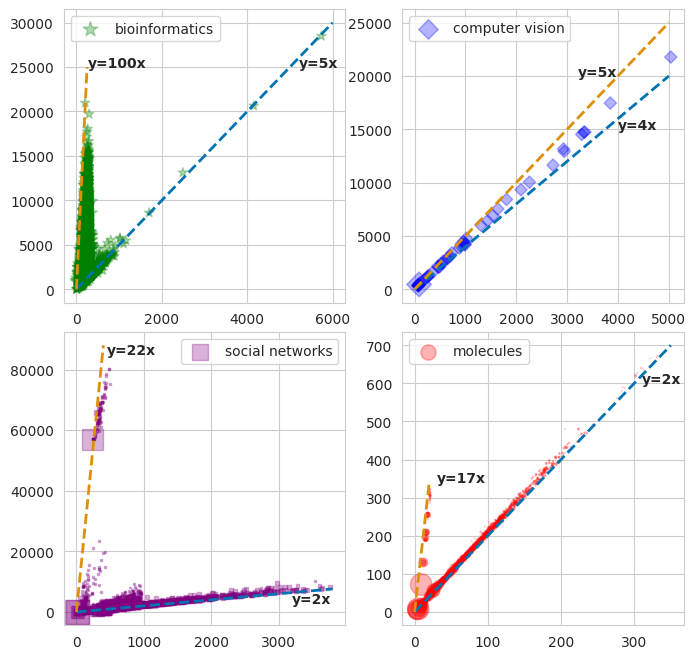

In [37]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs = axs.flatten()
for index, domain in enumerate(domains[:4]):
    x = [f[0] for f in features_list if f[2] == domain]
    y = [f[1] for f in features_list if f[2] == domain]
    s = [size_times[index]*f[3]**2 for f in features_list if f[2] == domain]
    axs[index].scatter(x, y, marker=shapes[index], label=domain, color=cmap[index], s=s, alpha=0.3)
    if domain == 'bioinformatics':
        axs[index].plot([0, 6000], [0, 30000], '--', linewidth=2)
        axs[index].annotate('y=5x', (5200, 25000), fontsize=10, weight='bold')
        axs[index].plot([0, 250], [0, 25000], '--', linewidth=2)
        axs[index].annotate('y=100x', (260, 25000), fontsize=10, weight='bold')
    elif domain == 'computer vision':
        axs[index].plot([0, 5000], [0, 20000], '--', linewidth=2)
        axs[index].annotate('y=4x', (4000, 15000), fontsize=10, weight='bold')
        axs[index].plot([0, 5000], [0, 25000], '--', linewidth=2)
        axs[index].annotate('y=5x', (3200, 20000), fontsize=10, weight='bold')
    elif domain == 'social networks':
        axs[index].plot([0, 3800], [0, 7600], '--', linewidth=2)
        axs[index].annotate('y=2x', (3200, 3000), fontsize=10, weight='bold')
        axs[index].plot([0, 400], [0, 88000], '--', linewidth=2)
        axs[index].annotate('y=22x', (450, 85000), fontsize=10, weight='bold')
    elif domain == 'molecules':
        axs[index].plot([0, 350], [0, 700], '--', linewidth=2)
        axs[index].annotate('y=2x', (310, 600), fontsize=10, weight='bold')
        axs[index].plot([0, 20], [0, 340], '--', linewidth=2)
        axs[index].annotate('y=17x', (30, 340), fontsize=10, weight='bold')
    # use log scale for x and y axis
    # axs[index].set_xscale('log')
    # axs[index].set_yscale('log')
    axs[index].legend()
# set the x-axis and y-axis labels for the whole figure
# fig.supxlabel('#Nodes', fontsize=12)
# fig.supylabel('#Edges', fontsize=12)
fig.subplots_adjust(wspace=0.2, hspace=0.1)
fig.savefig('plots/final/n_vs_m_sep.pdf', bbox_inches='tight', format='pdf')

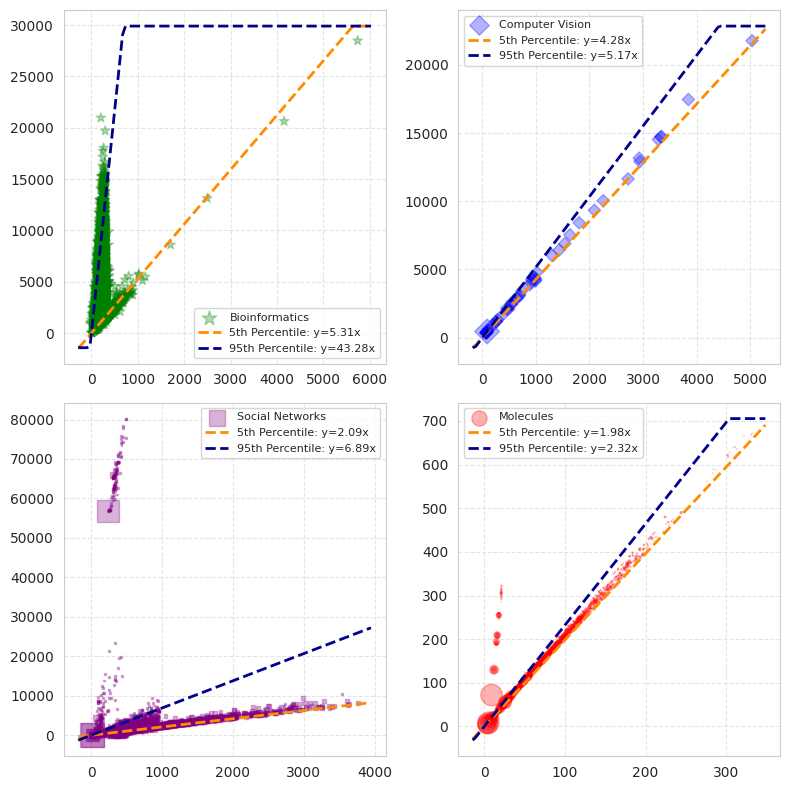

In [38]:
# Create subplots (2x2 grid as in original code)
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs = axs.flatten()

# Iterate over each domain (only the first 4 as per original code)
for index, domain in enumerate(domains[:4]):
    # Extract features for the current domain
    domain_features = [f for f in features_list if f[2] == domain]
    x = [f[0] for f in domain_features]
    y = [f[1] for f in domain_features]
    s = [size_times[index] * (f[3] ** 2) for f in domain_features]
    
    # Scatter plot for the current domain
    # capitalize the first letter of every word in the domain name
    domain = ' '.join([word.capitalize() for word in domain.split()])
    scatter = axs[index].scatter(
        x, y,
        marker=shapes[index],
        label=domain,
        color=cmap[index],
        s=s,
        alpha=0.3
    )
    
    # Compute slope a = y / x for all valid points (x > 0)
    a_values = [yi / xi for xi, yi in zip(x, y) if xi > 0]
    
    if a_values:
        # Calculate the 5th and 95th percentiles of a
        a_low = np.percentile(a_values, 5)
        a_high = np.percentile(a_values, 95)
        
        # Retrieve current axis limits
        x_limits = axs[index].get_xlim()
        y_limits = axs[index].get_ylim()
        
        # Define x range for the percentile lines based on existing x limits
        x_line = np.linspace(x_limits[0], x_limits[1], 100)
        
        # Compute y values for the percentile lines
        y_low = a_low * x_line
        y_high = a_high * x_line
        
        # Clip y values to existing y limits to prevent altering the y-axis range
        y_low = np.clip(y_low, y_limits[0], y_limits[1])
        y_high = np.clip(y_high, y_limits[0], y_limits[1])
        
        # Plot the 5th percentile line
        axs[index].plot(
            x_line, y_low,
            linestyle='--',
            linewidth=2,
            color='darkOrange',
            label=f'5th Percentile: y={a_low:.2f}x'
        )
        
        # Plot the 95th percentile line
        axs[index].plot(
            x_line, y_high,
            linestyle='--',
            linewidth=2,
            color='darkBlue',
            label=f'95th Percentile: y={a_high:.2f}x'
        )
        
    # Set titles and labels
    # axs[index].set_title(f'Domain: {domain.capitalize()}')
    # axs[index].set_xlabel('#Nodes')
    # axs[index].set_ylabel('#Edges')
    axs[index].legend(fontsize=8)
    
    # Optional: Set grid for better readability
    axs[index].grid(True, linestyle='--', alpha=0.5)

# Adjust layout for better spacing
fig.tight_layout()

# Save the figure
fig.savefig('plots/final/n_vs_m_sep_percentiles.pdf', bbox_inches='tight', format='pdf')
plt.show()